<a href="https://colab.research.google.com/github/gstdl/Brazilian_e-Commerce_Exploartory_Data_Analysis_and_Machine_Learning/blob/master/Brazillian_E_Commerce_EDA_Data_Merging_%26_Geospatial_Analysis_(Part_3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Libraries and Downloading Datasets.

*Please your own kaggle token to download the files on Google Colab*

In [0]:
# !pip install yellowbrick
# !pip install mlrose
!pip install matplotlib==3.0.3
!pip install geopandas
!pip install kaggle
# !pip install --upgrade git+https://github.com/scikit-learn-contrib/hdbscan.git#egg=hdbscan
!mkdir kaggle
import json
token = {"username":"use your own username","key":"use your own key"}
with open('/content/kaggle/kaggle.json','w') as file:
  json.dump(token,file)
!mkdir ../root/.kaggle
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d gstdl09/brazilian-ecommerce-pickled
!unzip /content/{/content}/datasets/gstdl09/brazilian-ecommerce-pickled/brazilian-ecommerce-pickled.zip

mkdir: cannot create directory ‘kaggle’: File exists
mkdir: cannot create directory ‘../root/.kaggle’: File exists
- path is now set to: {/content}
 71% 59.0M/83.0M [00:00<00:00, 54.3MB/s]
100% 83.0M/83.0M [00:00<00:00, 95.2MB/s]
Archive:  /content/{/content}/datasets/gstdl09/brazilian-ecommerce-pickled/brazilian-ecommerce-pickled.zip
replace gb_geo? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: gb_geo                  
  inflating: lat_lng.csv             
  inflating: pkl_dfCustomers.csv     
  inflating: pkl_dfGeolocation.csv   
  inflating: pkl_dfItems.csv         
  inflating: pkl_dfMerged.csv        
  inflating: pkl_dfOrders.csv        
  inflating: pkl_dfPayments.csv      
  inflating: pkl_dfProducts.csv      
  inflating: pkl_dfReviews.csv       
  inflating: pkl_dfSellers.csv       


In [0]:
import pickle
import pandas as pd
import numpy as np

In [0]:
dfProducts=pickle.load(open('pkl_dfProducts.csv','rb'))
dfPayments=pickle.load(open('pkl_dfPayments.csv','rb'))
dfGeolocation=pickle.load(open('pkl_dfGeolocation.csv','rb'))
dfCustomers=pickle.load(open('pkl_dfCustomers.csv','rb'))
dfSellers=pickle.load(open('pkl_dfSellers.csv','rb'))
dfOrders=pickle.load(open('pkl_dfOrders.csv','rb'))
dfReviews=pickle.load(open('pkl_dfReviews.csv','rb'))
dfItems=pickle.load(open('pkl_dfItems.csv','rb'))

In [0]:
dataframes=[x for x in dir() if 'df' in x]
dataframes

['dfCustomers',
 'dfGeolocation',
 'dfItems',
 'dfOrders',
 'dfPayments',
 'dfProducts',
 'dfReviews',
 'dfSellers']

In [0]:
dfs=[dfCustomers,
     dfGeolocation,
     dfItems,
     dfOrders,
     dfPayments,
     dfProducts,
     dfReviews,
     dfSellers]

In [0]:
pd.set_option('display.max_columns', 999999999)
pd.set_option('display.max_rows', 999999999)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd

from time import time

# import re

def resumetable(df):
    summary = pd.DataFrame(dict(dataFeatures=df.columns,
                             dataType=df.dtypes,
                             null=df.isna().sum(),
                             nullPct=round(df.isna().sum()/len(df)*100,2),
                             unique=df.nunique(),
#                              uniqueSample=[list(df[i].drop_duplicates().sample(2)) for i in df.columns]
                            )).set_index('dataFeatures')
    
    for feature in summary.index:
        for s in ['mostValue','leastValue']:
            for i in range(3):
                if s=='leastValue':
                    j=-(1+i)
                else:
                    j=i
                try:
                    idx=df[feature].dropna().value_counts().index[j]
                    summary.loc[feature,f'{s}_{i+1}']=idx
                    summary.loc[feature,f'{s}Count_{i+1}']=df[feature].dropna().value_counts()[idx]
                except:
                    summary.loc[feature,f'{s}_{i+1}']='-'
                    summary.loc[feature,f'{s}Count_{i+1}']='-'
    return summary

In [0]:
def check_row_names():
    dupes=[]
    pks=['order_id','customer_id','product_id','seller_id','zip_code_prefix']
#     print('%s shape is %s'%('product_category_translate',product_category_translate.shape))
    for name_1,df_1 in zip(dataframes,dfs):
        print('%s shape is %s'%(name_1,df_1.shape))
        for name_2,df_2 in zip(dataframes,dfs):
            if list(df_1.columns)!=list(df_2.columns):
                for col_1 in df_1.columns:
                    for col_2 in df_2.columns:
                        if col_1==col_2 and col_1 not in pks:
                            dupes.append(col_1)
                if len(dupes)>0:
                    print('%s and %s has duplicate columns names, the duplicates are listed below.'%(name_1,name_2))
                    print(dupes)
            dupes=[]

    print('Finished checking for duplicate columns.')
check_row_names()

dfCustomers shape is (99441, 5)
dfGeolocation shape is (1000163, 9)
dfItems shape is (112650, 7)
dfOrders shape is (99441, 8)
dfPayments shape is (103886, 5)
dfProducts shape is (32951, 9)
dfReviews shape is (100000, 7)
dfSellers shape is (3095, 4)
Finished checking for duplicate columns.


In [0]:
for name_1,df_1 in zip(dataframes,dfs):
    print('-'*10,name_1,'-'*10)
    print(df_1.info())
    print('_'*30)

---------- dfCustomers ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
customer_id                 99441 non-null object
customer_unique_id          99441 non-null object
customer_zip_code_prefix    99441 non-null object
customer_city               99441 non-null object
customer_state              99441 non-null object
dtypes: object(5)
memory usage: 3.8+ MB
None
______________________________
---------- dfGeolocation ----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 9 columns):
geolocation_zip_code_prefix    1000163 non-null object
geolocation_lat                1000163 non-null float64
geolocation_lng                1000163 non-null float64
geolocation_city               1000163 non-null object
geolocation_state              1000163 non-null object
geometry                       1000163 non-null geometry
in_brazil                      1000163 non-null in

## Merging Scheme
### E-COMMERCE PUBLIC DATASET SCHEME
![](https://i.imgur.com/HRhd2Y0.png)

In [0]:
def merge(l,r,pk):
    start=time()
    print(f'{pk} nunique on left df = {l[pk].nunique()}')
    print(f'{pk} nunique on right df = {r[pk].nunique()}')
    df = pd.merge(l,r,on=pk)
    print(f'finished merging in {round(time()-start,2)}s')
    return df

In [0]:
dfMerged=merge(dfItems,dfSellers,'seller_id')

seller_id nunique on left df = 3095
seller_id nunique on right df = 3095
finished merging in 0.06s


In [0]:
dfMerged=merge(dfMerged,dfProducts,'product_id')

product_id nunique on left df = 32951
product_id nunique on right df = 32951
finished merging in 0.07s


In [0]:
dfMerged=merge(dfOrders,dfMerged,'order_id')

order_id nunique on left df = 99441
order_id nunique on right df = 98666
finished merging in 0.22s


In [0]:
dfMerged=merge(dfMerged,dfCustomers,'customer_id')

customer_id nunique on left df = 98666
customer_id nunique on right df = 99441
finished merging in 0.16s


In [0]:
dfMerged=merge(dfMerged,dfPayments,'order_id')

order_id nunique on left df = 98666
order_id nunique on right df = 99440
finished merging in 0.15s


In [0]:
dfMerged=merge(dfMerged,dfReviews,'order_id')

order_id nunique on left df = 98665
order_id nunique on right df = 99441
finished merging in 0.19s


In [0]:
pickle.dump(dfMerged,open('pkl_dfMerged.csv','wb'))

In [0]:
dfMerged.head()

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
2  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
3  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
4  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
2    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
3    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
4    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2017-10-04 19:55:00           2017-10-10 21:25:13   
2          2017-10-04 19:55:00           2017-10-10 21:25:13   
3          2018-07-26 14:31:00           2018-08-07 15:27:45   
4          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  order_item_id  \
0                    2017-10-18              1   
1                    2017-10-18              1   
2                    2017-10-18              1   
3                    2018-08-13              1   
4                    2018-09-04              1   

                         product_id                         seller_id  \
0  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
1  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
2  87285b34884572647811a353c7ac498a  3504c0cb71d7fa48d967e0e4c94d59d9   
3  595fac2a385ac33a80bd5114aec74eb8  289cdb325fb7e7f891c38608bf9e0962   
4  aa4383b373c6aca5d8797843e5594415  4869f7a5dfa277a7dca6462dcf3b52b2   

  shipping_limit_date   price  freight_value seller_zip_code_prefix  \
0 2017-10-06 11:07:15   29.99           8.72                  09350   
1 2017-10-06 11:07:15   29.99           8.72                  09350   
2 2017-10-06 11:07:15   29.99           8.72                  09350   
3 2018-07-30 03:24:27  118.70          22.76                  31570   
4 2018-08-13 08:55:23  159.90          19.22                  14840   

      seller_city seller_state product_category_name  product_name_lenght  \
0            maua           SP            housewares                 40.0   
1            maua           SP            housewares                 40.0   
2            maua           SP            housewares                 40.0   
3  belo horizonte           SP             perfumery                 29.0   
4         guariba           SP                  auto                 46.0   

   product_description_lenght  product_photos_qty  product_weight_g  \
0                       268.0                 4.0             500.0   
1                       268.0                 4.0             500.0   
2                       268.0                 4.0             500.0   
3                       178.0                 1.0             400.0   
4                       232.0                 1.0             420.0   

   product_length_cm  product_height_cm  product_width_cm  \
0               19.0                8.0              13.0   
1               19.0                8.0              13.0   
2               19.0                8.0              13.0   
3               19.0               13.0              19.0   
4               24.0               19.0              21.0   

                 customer_unique_id customer_zip_code_prefix customer_city  \
0  7c396fd4830fd04220f754e42b4e5bff                    03149     sao paulo   
1  7c396fd4830fd04220f754e42b4e5bff                    03149     sao paulo   
2  7c396fd4830fd04220f754e42b4e5bff                    03149     sao paulo   
3  af07308b275d755c9edb36a90c618231                    47813     barreiras   
4  3a653a4

In [0]:
dfMerged.shape

(118315, 39)

In [0]:
resumetable(dfMerged)

dataType    null  nullPct  unique  \
dataFeatures                                                             
order_id                               object       0     0.00   98665   
customer_id                            object       0     0.00   98665   
order_status                           object       0     0.00       7   
order_purchase_timestamp       datetime64[ns]       0     0.00   98111   
order_approved_at              datetime64[ns]      15     0.01   90173   
order_delivered_carrier_date   datetime64[ns]    1254     1.06   81016   
order_delivered_customer_date  datetime64[ns]    2588     2.19   95663   
order_estimated_delivery_date  datetime64[ns]       0     0.00     449   
order_item_id                           int64       0     0.00      21   
product_id                             object       0     0.00   32951   
seller_id                              object       0     0.00    3095   
shipping_limit_date            datetime64[ns]       0     0.00   93317   
price                                 float64       0     0.00    5968   
freight_value                         float64       0     0.00    6999   
seller_zip_code_prefix                 object       0     0.00    2246   
seller_city                            object       0     0.00     610   
seller_state                           object       0     0.00      23   
product_category_name                  object    1709     1.44      73   
product_name_lenght                   float64    1709     1.44      66   
product_description_lenght            float64    1709     1.44    2960   
product_photos_qty                    float64    1709     1.44      19   
product_weight_g                      float64      19     0.02    2204   
product_length_cm                     float64      19     0.02      99   
product_height_cm                     float64      19     0.02     102   
product_width_cm                      float64      19     0.02      95   
customer_unique_id                     object       0     0.00   95419   
customer_zip_code_prefix               object       0     0.00   14976   
customer_city                          object       0     0.00    4110   
customer_state                         object       0     0.00      27   
payment_sequential                      int64       0     0.00      29   
payment_type                           object       0     0.00       4   
payment_installments                    int64       0     0.00      24   
payment_value                         float64       0     0.00   28938   
review_id                              object       0     0.00   98452   
review_score                            int64       0     0.00       5   
review_comment_title                   object  104226    88.09    4569   
review_comment_message                 object   67650    57.18   36434   
review_creation_date           datetime64[ns]       0     0.00     633   
review_answer_timestamp        datetime64[ns]       0     0.00   98290   

                                                    mostValue_1  \
dataFeatures                                                      
order_id                       895ab968e7bb0d5659d16cd74cd1650c   
customer_id                    270c23a11d024a44c896d1894b261a83   
order_status                                          delivered   
order_purchase_timestamp                    2017-08-08 20:26:31   
order_approved_at                           2017-08-08 20:43:31   
order_delivered_carrier_date                2017-08-10 11:58:14   
order_delivered_customer_date               2017-08-14 12:46:18   
order_estimated_delivery_date               2017-12-20 00:00:00   
order_item_id                                                 1   
product_id                     aca2eb7d00ea1a7b8ebd4e68314663af   
seller_id                      4a3ca9315b744ce9f8e9374361493884   
shipping_limit_date                         2017-08-14 20:43:31   
price                                                      59.9 

In [0]:
dfGeolocation.head()

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                       01037       -23.545621       -46.639292   
1                       01046       -23.546081       -46.644820   
2                       01046       -23.546129       -46.642951   
3                       01041       -23.544392       -46.639499   
4                       01035       -23.541578       -46.641607   

  geolocation_city geolocation_state                     geometry  in_brazil  \
0        sao paulo                SP  POINT (-46.63929 -23.54562)          1   
1        sao paulo                SP  POINT (-46.64482 -23.54608)          1   
2        sao paulo                SP  POINT (-46.64295 -23.54613)          1   
3        sao paulo                SP  POINT (-46.63950 -23.54439)          1   
4        sao paulo                SP  POINT (-46.64161 -23.54158)          1   

              cs  frequency_in_dfGeolocation  
0  sao paulo, SP                          26  
1  sao paulo, SP                         141  
2  sao paulo, SP                         141  
3  sao paulo, SP                          25  
4  sao paulo, SP                          39

In [0]:
dfGeolocation.shape

(1000163, 9)

In [0]:
dfGeolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 9 columns):
geolocation_zip_code_prefix    1000163 non-null object
geolocation_lat                1000163 non-null float64
geolocation_lng                1000163 non-null float64
geolocation_city               1000163 non-null object
geolocation_state              1000163 non-null object
geometry                       1000163 non-null geometry
in_brazil                      1000163 non-null int64
cs                             1000163 non-null object
frequency_in_dfGeolocation     1000163 non-null int64
dtypes: float64(2), geometry(1), int64(2), object(4)
memory usage: 68.7+ MB


In [0]:
dfGeolocation.drop(['cs','frequency_in_dfGeolocation','geometry'],axis=1,inplace=True)
gb_geo = dfGeolocation[dfGeolocation['in_brazil']==1].groupby(['geolocation_zip_code_prefix','geolocation_state','geolocation_city']).mean()

In [0]:
gb_geo.head()

geolocation_lat  \
geolocation_zip_code_prefix geolocation_state geolocation_city                    
01001                       SP                sao paulo              -23.550190   
01002                       SP                sao paulo              -23.548146   
01003                       SP                sao paulo              -23.548994   
01004                       SP                sao paulo              -23.549799   
01005                       SP                sao paulo              -23.549456   

                                                                geolocation_lng  \
geolocation_zip_code_prefix geolocation_state geolocation_city                    
01001                       SP                sao paulo              -46.634024   
01002                       SP                sao paulo              -46.634979   
01003                       SP                sao paulo              -46.635731   
01004                       SP                sao paulo              -46.634757   
01005                       SP                sao paulo              -46.636733   

                                                                in_brazil  
geolocation_zip_code_prefix geolocation_state geolocation_city             
01001                       SP                sao paulo                 1  
01002                       SP                sao paulo                 1  
01003                       SP                sao paulo                 1  
01004                       SP                sao paulo                 1  
01005                       SP                sao paulo                 1

In [0]:
gb_geo.describe()

geolocation_lat  geolocation_lng  in_brazil
count     19610.000000     19610.000000    19610.0
mean        -19.050721       -46.091263        1.0
std           7.203151         5.201013        0.0
min         -33.689948       -72.916069        1.0
25%         -23.561028       -48.963723        1.0
50%         -22.353093       -46.635854        1.0
75%         -15.638533       -43.268057        1.0
max           4.478955       -34.799347        1.0

In [0]:
gb_geo.loc[('01001','SP','sao paulo'),'geolocation_lat']

-23.550189776551765

In [0]:
def get_lat(x):
  try:
    return gb_geo.loc[(x[0],x[1],x[2]),'geolocation_lat']
  except:
    return np.nan

def get_lng(x):
  try:
    return gb_geo.loc[(x[0],x[1],x[2]),'geolocation_lng']
  except:
    return np.nan
    
dfMerged['customer_lat']=dfMerged[['customer_zip_code_prefix','customer_state','customer_city']].apply(get_lat,axis=1)
dfMerged['customer_lng']=dfMerged[['customer_zip_code_prefix','customer_state','customer_city']].apply(get_lng,axis=1)
dfMerged['seller_lat']=dfMerged[['seller_zip_code_prefix','seller_state','seller_city']].apply(get_lat,axis=1)
dfMerged['seller_lng']=dfMerged[['seller_zip_code_prefix','seller_state','seller_city']].apply(get_lng,axis=1)

In [0]:
dfMerged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118315 entries, 0 to 118314
Data columns (total 43 columns):
order_id                         118315 non-null object
customer_id                      118315 non-null object
order_status                     118315 non-null object
order_purchase_timestamp         118315 non-null datetime64[ns]
order_approved_at                118300 non-null datetime64[ns]
order_delivered_carrier_date     117061 non-null datetime64[ns]
order_delivered_customer_date    115727 non-null datetime64[ns]
order_estimated_delivery_date    118315 non-null datetime64[ns]
order_item_id                    118315 non-null int64
product_id                       118315 non-null object
seller_id                        118315 non-null object
shipping_limit_date              118315 non-null datetime64[ns]
price                            118315 non-null float64
freight_value                    118315 non-null float64
seller_zip_code_prefix           118315 non-null object


### Geospatial Analysis

In [0]:
dfGeoCustomer=gpd.GeoDataFrame(dfMerged[['customer_id','customer_lng','customer_lat','payment_value']], geometry=gpd.points_from_xy(dfMerged['customer_lng'], dfMerged['customer_lat']))
dfGeoSeller=gpd.GeoDataFrame(dfMerged[['seller_id','seller_lng','seller_lat','price']], geometry=gpd.points_from_xy(dfMerged['seller_lng'], dfMerged['seller_lat']))
dfOrder=dfMerged.copy()[['order_id','customer_lng','customer_lat','seller_lng','seller_lat','freight_value','product_category_name','customer_id','seller_id']]
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
brazil = world[world['name']=='Brazil']

In [0]:
dfGeoCustomer.head()

customer_id  customer_lng  customer_lat  \
0  9ef432eb6251297304e76186b10a928d    -46.587161    -23.576983   
1  9ef432eb6251297304e76186b10a928d    -46.587161    -23.576983   
2  9ef432eb6251297304e76186b10a928d    -46.587161    -23.576983   
3  b0830fb4747a6c6d20dea0b8c802d7ef    -44.660711    -12.177924   
4  41ce2a54c0b03bf3443c3d931a367089    -48.514783    -16.745150   

   payment_value                     geometry  
0          18.12  POINT (-46.58716 -23.57698)  
1           2.00  POINT (-46.58716 -23.57698)  
2          18.59  POINT (-46.58716 -23.57698)  
3         141.46  POINT (-44.66071 -12.17792)  
4         179.12  POINT (-48.51478 -16.74515)

/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


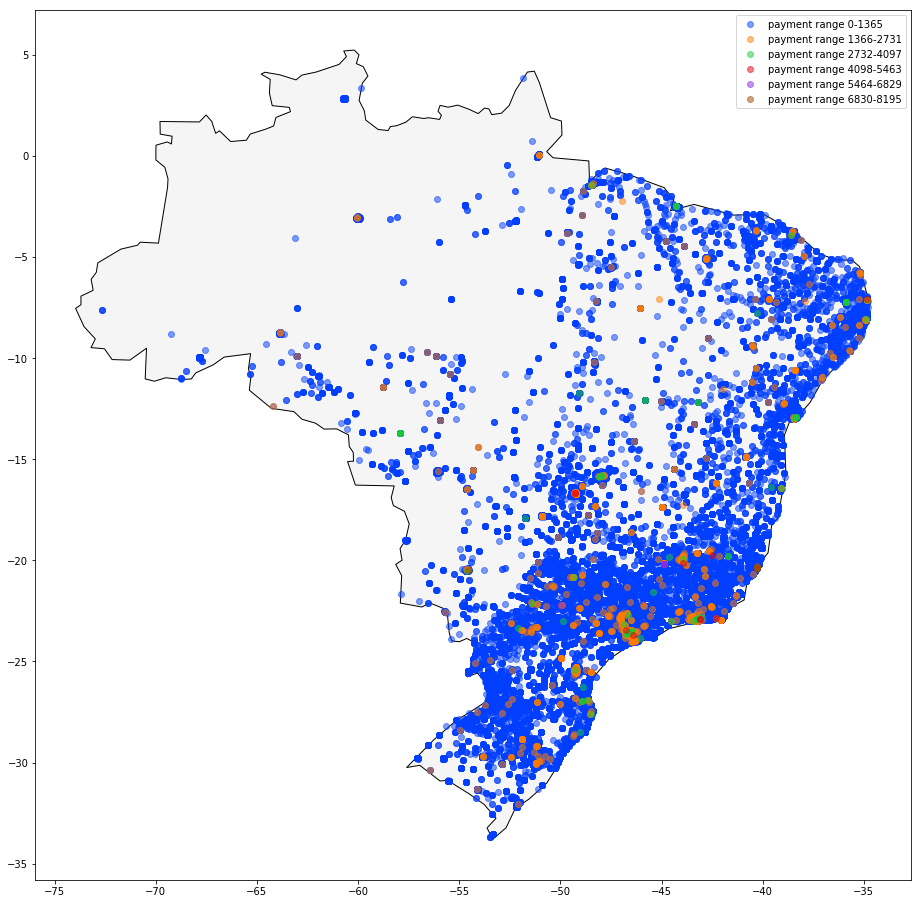

In [0]:
bins=10
ax=brazil.plot(color='whitesmoke',edgecolor='black',figsize=(18,16))
step=int(dfGeoCustomer['payment_value'].max()/bins)
color=sns.color_palette('bright')
legend=[]
for val,c in zip(range(int(dfGeoCustomer['payment_value'].min()),int(dfGeoCustomer['payment_value'].max())+1,step),color):
  dfGeoCustomer[dfGeoCustomer['payment_value'].between(val,val+step-1)].plot(ax=ax,color=c,alpha=0.5)
  legend.append(f'payment range {val}-{val+step-1}')
plt.legend(legend)

In [0]:
dfGeoSeller.head()

seller_id  seller_lng  seller_lat   price  \
0  3504c0cb71d7fa48d967e0e4c94d59d9  -46.444238  -23.680729   29.99   
1  3504c0cb71d7fa48d967e0e4c94d59d9  -46.444238  -23.680729   29.99   
2  3504c0cb71d7fa48d967e0e4c94d59d9  -46.444238  -23.680729   29.99   
3  289cdb325fb7e7f891c38608bf9e0962         NaN         NaN  118.70   
4  4869f7a5dfa277a7dca6462dcf3b52b2  -48.229601  -21.363502  159.90   

                  geometry  
0  POINT (-46.444 -23.681)  
1  POINT (-46.444 -23.681)  
2  POINT (-46.444 -23.681)  
3          POINT (nan nan)  
4  POINT (-48.230 -21.364)

/usr/local/lib/python3.6/dist-packages/geopandas/plotting.py:510: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


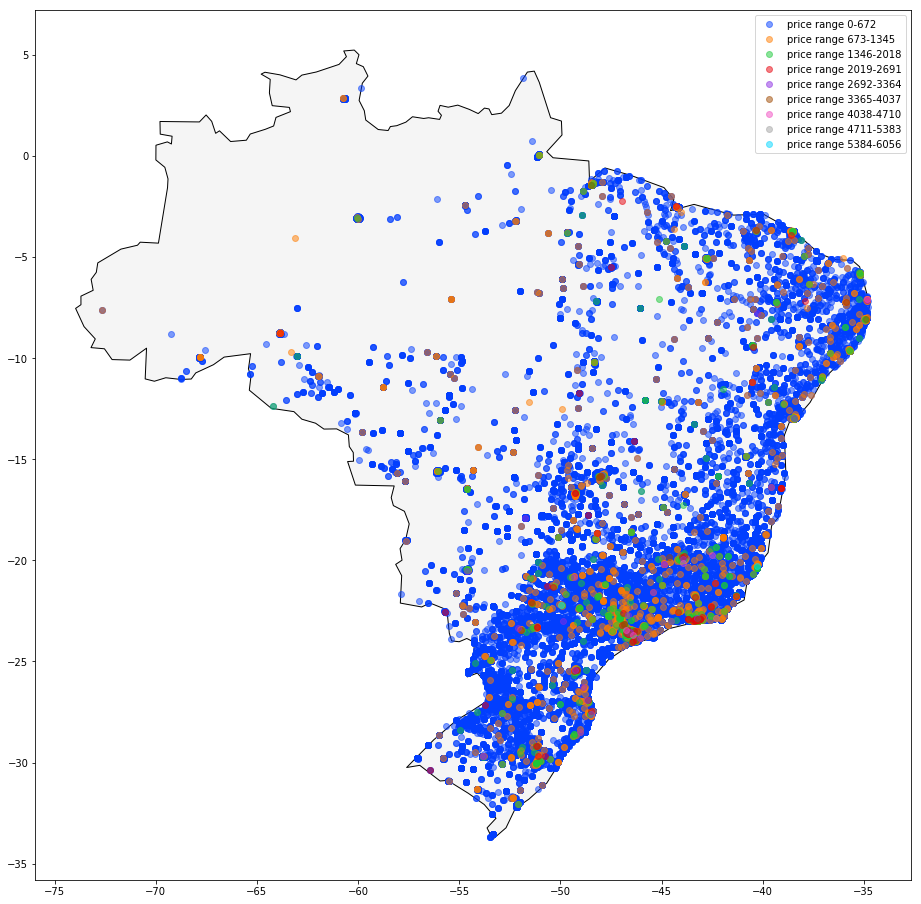

In [0]:
bins=10
ax=brazil.plot(color='whitesmoke',edgecolor='black',figsize=(18,16))
step=int(dfGeoSeller['price'].max()//bins)
color=sns.color_palette('bright')
legend=[]
for val,c in zip(range(int(dfGeoSeller['price'].min()),int(dfGeoSeller['price'].max())+1,step),color):
  dfGeoCustomer[dfGeoSeller['price'].between(val,val+step-1)].plot(ax=ax,color=c,alpha=0.5)
  legend.append(f'price range {val}-{val+step-1}')
plt.legend(legend)

In [0]:
dfOrder.head()

order_id  customer_lng  customer_lat  seller_lng  \
0  e481f51cbdc54678b7cc49136f2d6af7    -46.587161    -23.576983  -46.444238   
1  e481f51cbdc54678b7cc49136f2d6af7    -46.587161    -23.576983  -46.444238   
2  e481f51cbdc54678b7cc49136f2d6af7    -46.587161    -23.576983  -46.444238   
3  53cdb2fc8bc7dce0b6741e2150273451    -44.660711    -12.177924         NaN   
4  47770eb9100c2d0c44946d9cf07ec65d    -48.514783    -16.745150  -48.229601   

   seller_lat  freight_value product_category_name  \
0  -23.680729           8.72            housewares   
1  -23.680729           8.72            housewares   
2  -23.680729           8.72            housewares   
3         NaN          22.76             perfumery   
4  -21.363502          19.22                  auto   

                        customer_id                         seller_id  
0  9ef432eb6251297304e76186b10a928d  3504c0cb71d7fa48d967e0e4c94d59d9  
1  9ef432eb6251297304e76186b10a928d  3504c0cb71d7fa48d967e0e4c94d59d9  
2  9ef432eb6251297304e76186b10a928d  3504c0cb71d7fa48d967e0e4c94d59d9  
3  b0830fb4747a6c6d20dea0b8c802d7ef  289cdb325fb7e7f891c38608bf9e0962  
4  41ce2a54c0b03bf3443c3d931a367089  4869f7a5dfa277a7dca6462dcf3b52b2

In [0]:
def get_distance(cols):
  if np.nan in cols:
    return np.nan
  else:
    return np.sqrt((cols[0]-cols[2])**2+(cols[1]-cols[3])**2)

dfOrder['distance']=dfOrder[['customer_lng','customer_lat','seller_lng','seller_lat']].apply(get_distance,axis=1)

In [0]:
dfOrder.head()

order_id  customer_lng  customer_lat  seller_lng  \
0  e481f51cbdc54678b7cc49136f2d6af7    -46.587161    -23.576983  -46.444238   
1  e481f51cbdc54678b7cc49136f2d6af7    -46.587161    -23.576983  -46.444238   
2  e481f51cbdc54678b7cc49136f2d6af7    -46.587161    -23.576983  -46.444238   
3  53cdb2fc8bc7dce0b6741e2150273451    -44.660711    -12.177924         NaN   
4  47770eb9100c2d0c44946d9cf07ec65d    -48.514783    -16.745150  -48.229601   

   seller_lat  freight_value product_category_name  \
0  -23.680729           8.72            housewares   
1  -23.680729           8.72            housewares   
2  -23.680729           8.72            housewares   
3         NaN          22.76             perfumery   
4  -21.363502          19.22                  auto   

                        customer_id                         seller_id  \
0  9ef432eb6251297304e76186b10a928d  3504c0cb71d7fa48d967e0e4c94d59d9   
1  9ef432eb6251297304e76186b10a928d  3504c0cb71d7fa48d967e0e4c94d59d9   
2  9ef432eb6251297304e76186b10a928d  3504c0cb71d7fa48d967e0e4c94d59d9   
3  b0830fb4747a6c6d20dea0b8c802d7ef  289cdb325fb7e7f891c38608bf9e0962   
4  41ce2a54c0b03bf3443c3d931a367089  4869f7a5dfa277a7dca6462dcf3b52b2   

   distance  
0  0.176608  
1  0.176608  
2  0.176608  
3       NaN  
4  4.627149

In [0]:
dfOrder['distance'].describe()

count    115302.000000
mean          5.544084
std           5.355580
min           0.000000
25%           1.741836
50%           4.077161
75%           7.387452
max          32.354430
Name: distance, dtype: float64

In [0]:
from shapely.geometry import LineString
dfPath=pd.merge(dfGeoCustomer['geometry'],dfGeoSeller['geometry'],left_index=True,right_index=True).apply(list).apply(lambda x:LineString(x))
dfPath=gpd.GeoDataFrame(geometry=dfPath)

In [0]:
dfPath.head()

geometry
geometry_x  LINESTRING (-46.58716 -23.57698, -46.58716 -23...
geometry_y  LINESTRING (-46.44424 -23.68073, -46.44424 -23...

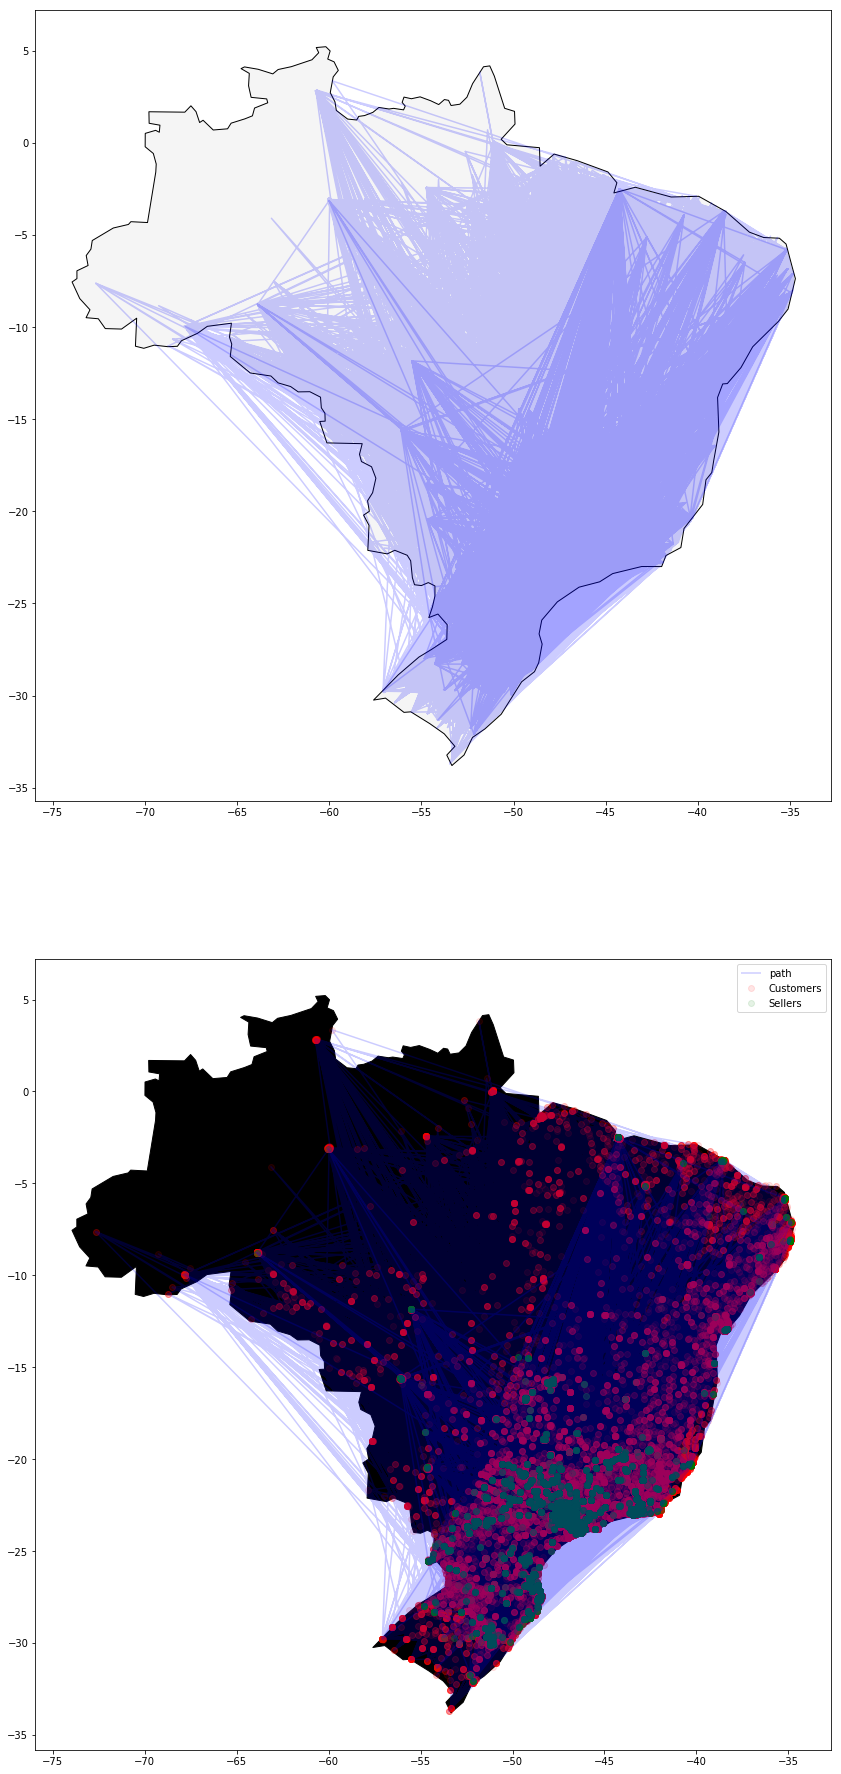

In [0]:
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(18,32))
ax1.figsize=(18,16)
ax2.figsize=(18,16)
brazil.plot(color='whitesmoke',edgecolor='black',ax=ax1)
dfPath.plot(ax=ax1,alpha=.2,color='blue')
brazil.plot(color='black',edgecolor='black',ax=ax2)
dfPath.plot(ax=ax2,alpha=.2,color='blue')
dfGeoCustomer.plot(ax=ax2,color='red',alpha=.1)
dfGeoSeller.plot(ax=ax2,alpha=0.1,color='green')
ax2.legend(['path','Customers','Sellers'])

#### Interesting Insights
Based on the maps above, there are several information that can be inferred. The inferred information are listed below.

1. There doesn't seem to be a particular area where customer's buying power is high nor low.
2. Similarly, there is also no particular area where the items being sold is high nor low.
3. Most of the deliveries are made on the East side of Brazil.
4. Most of the sellers are located on the South-East side of Brazil.

In [0]:
pickle.dump(gb_geo,open('gb_geo','wb'))

### Merged DataFrame EDA

In [0]:
dfMerged['distance']=dfMerged[['customer_lng','customer_lat','seller_lng','seller_lat']].apply(get_distance,axis=1)

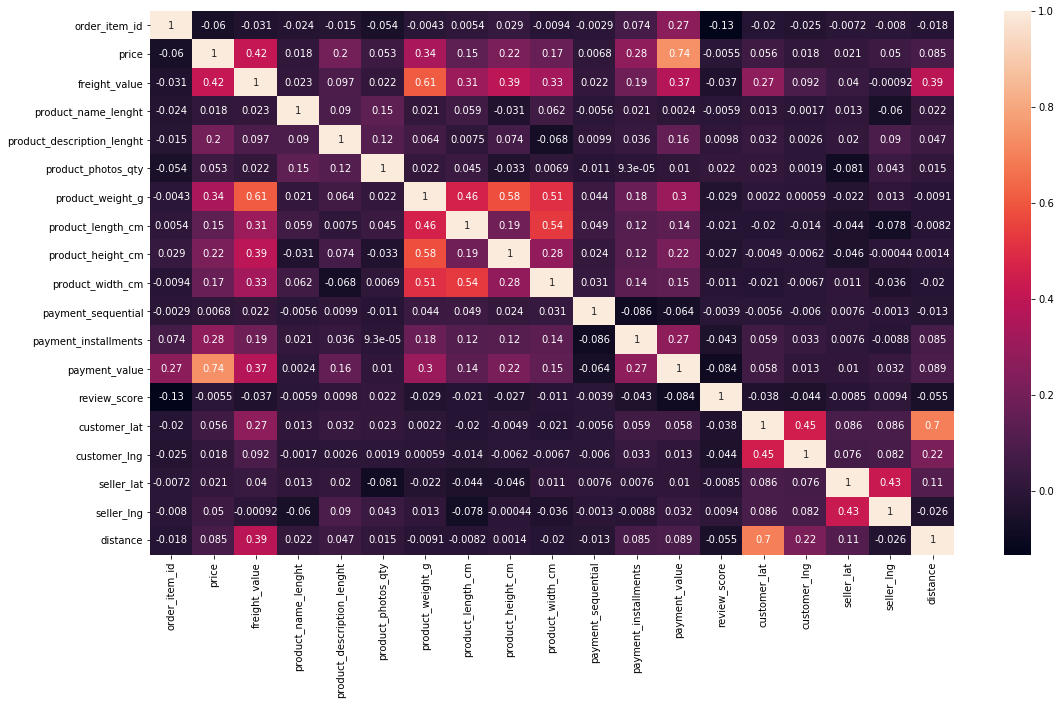

In [0]:
plt.figure(figsize=(18,10))
sns.heatmap(dfMerged.corr(),annot=True)

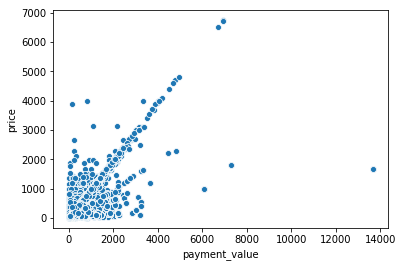

In [0]:
sns.scatterplot('payment_value','price',data=dfMerged)

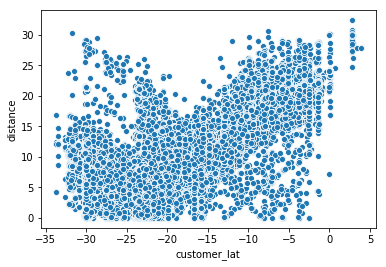

In [0]:
sns.scatterplot('customer_lat','distance',data=dfMerged)

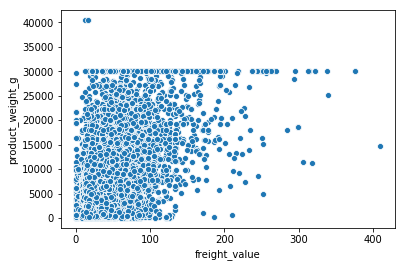

In [0]:
sns.scatterplot('freight_value','product_weight_g',data=dfMerged)

In [0]:
dfMerged[(dfMerged['freight_value']<100)&(dfMerged['product_weight_g']>30000)]

order_id                       customer_id  \
34735   4a45f9f66971302cf881ecfa142f42ba  ccd6a4af78390b7ae560c1cc1cb1a2ff   
95998   6ecf1a4051b4c5ed613624b460970a26  958279c23050d6207d196c3057648f6f   
107351  9223919b300f6989e1715333fca0d6ce  51934b734e94e61d8efa4523e175c6c3   

       order_status order_purchase_timestamp   order_approved_at  \
34735     delivered      2017-12-23 19:03:24 2017-12-23 19:13:20   
95998     delivered      2017-11-17 08:40:57 2017-11-17 08:55:48   
107351    delivered      2018-03-01 23:05:31 2018-03-01 23:15:32   

       order_delivered_carrier_date order_delivered_customer_date  \
34735           2017-12-28 15:13:58           2018-01-25 22:17:15   
95998           2017-11-17 20:36:56           2017-12-01 12:08:23   
107351          2018-03-02 22:33:58           2018-03-27 20:47:27   

       order_estimated_delivery_date  order_item_id  \
34735                     2018-01-29              1   
95998                     2017-12-06              1   
107351                    2018-03-26              1   

                              product_id                         seller_id  \
34735   26644690fde745fc4654719c3904e1db  1835b56ce799e6a4dc4eddc053f04066   
95998   26644690fde745fc4654719c3904e1db  1835b56ce799e6a4dc4eddc053f04066   
107351  26644690fde745fc4654719c3904e1db  1835b56ce799e6a4dc4eddc053f04066   

       shipping_limit_date  price  freight_value seller_zip_code_prefix  \
34735  2017-12-29 19:13:20   80.0          16.32                  14940   
95998  2017-11-23 08:55:48   80.0          12.06                  14940   
107351 2018-03-07 23:15:32   80.0          16.32                  14940   

       seller_city seller_state product_category_name  product_name_lenght  \
34735     ibitinga           SP        bed bath table                 59.0   
95998     ibitinga           SP        bed bath table                 59.0   
107351    ibitinga           SP        bed bath table                 59.0   

        product_description_lenght  product_photos_qty  product_weight_g  \
34735                        534.0                 1.0           40425.0   
95998                        534.0                 1.0           40425.0   
107351                       534.0                 1.0           40425.0   

        product_length_cm  product_height_cm  product_width_cm  \
34735                13.0               65.0              28.0   
95998                13.0               65.0              28.0   
107351               13.0               65.0              28.0   

                      customer_unique_id customer_zip_code_prefix  \
34735   32d0420a22921ea161d8bff0e0297b71                    88820   
95998   de00290d2a997f24e1706fdc2d366a0e                    11730   
107351  4fbb5c68b6851f6e35c543f963b43e4c                    86455   

         customer_city customer_state  payment_sequential payment_type  \
34735            icara             SC                   1  credit_card   
95998         mongagua             SP                   1  credit_card   
107351  joaquim tavora             PR                   1  credit_card   

        payment_installments  payment_value                         review_id  \
34735                      1          96.32  62a35e9e362cf9b27b9ee8e047afbedf   
95998                      2          92.06  13fe815dc5c4076ab42f34545df82ca1   
107351                     1          96.32  1474903cd02494e327de0317af95d846   

        review_score review_comment_title review_comment_message  \
34735              1                  NaN                    NaN   
95998              5                  NaN                    NaN   
107351             5                  NaN                    NaN   

       review_creation_date review_answer_timestamp  customer_lat  \
34735            2018-01-26     2018-01-27 00:42:30    -28.715980   
95998            2017-12-02     2017-12-04 16:04:31    -24.111896   
107351           2018-03-28     2018-03-30 12:39:00    -23.500213   

  

In [0]:
dfMerged[dfMerged['product_category_name'].isna()].describe()

order_item_id        price  freight_value  product_name_lenght  \
count    1709.000000  1709.000000    1709.000000                  0.0   
mean        1.167349   112.268239      18.043686                  NaN   
std         0.559220   198.265243      15.147995                  NaN   
min         1.000000     3.000000       0.000000                  NaN   
25%         1.000000    34.900000      11.850000                  NaN   
50%         1.000000    69.990000      15.230000                  NaN   
75%         1.000000   122.990000      18.230000                  NaN   
max         8.000000  3980.000000     162.080000                  NaN   

       product_description_lenght  product_photos_qty  product_weight_g  \
count                         0.0                 0.0       1690.000000   
mean                          NaN                 NaN       1883.907692   
std                           NaN                 NaN       4004.316688   
min                           NaN                 NaN         50.000000   
25%                           NaN                 NaN        300.000000   
50%                           NaN                 NaN        450.000000   
75%                           NaN                 NaN       1300.000000   
max                           NaN                 NaN      30000.000000   

       product_length_cm  product_height_cm  product_width_cm  \
count        1690.000000        1690.000000       1690.000000   
mean           26.671598          14.743195         20.207692   
std            13.271736          11.843327         10.782694   
min            15.000000           2.000000         11.000000   
25%            16.000000           7.000000         12.000000   
50%            20.000000          12.000000         15.000000   
75%            33.000000          20.000000         25.000000   
max           105.000000          92.000000         80.000000   

       payment_sequential  payment_installments  payment_value  review_score  \
count         1709.000000           1709.000000    1709.000000   1709.000000   
mean             1.142188              2.537156     148.465372      3.825044   
std              0.816418              2.320978     226.399686      1.531230   
min              1.000000              1.000000       0.130000      1.000000   
25%              1.000000              1.000000      54.000000      3.000000   
50%              1.000000              1.000000     112.140000      5.000000   
75%              1.000000              3.000000     162.550000      5.000000   
max             13.000000             10.000000    4042.740000      5.000000   

       customer_lat  customer_lng   seller_lat   seller_lng     distance  
count   1701.000000   1701.000000  1673.000000  1673.000000  1665.000000  
mean     -21.286441    -46.294249   -22.995850   -46.653190     5.230182  
std        5.532798      4.044532     2.080636     1.913365     5.316054  
min      -32.561057    -67.876759   -31.751072   -54.841000     0.003359  
25%      -23.583745    -48.449376   -23.539657   -47.404546     1.240211  
50%      -22.939430    -46.637671   -23.436711   -46.542091     3.902237  
75%      -20.139441    -43.733224   -22.560755   -46.511340     7.231682  
max        2.855558    -34.836183    -7.114711   -34.855616    29.857799

In [0]:
dfMerged[dfMerged['product_category_name'].notnull()].describe()

order_item_id          price  freight_value  product_name_lenght  \
count  116606.000000  116606.000000  116606.000000        116606.000000   
mean        1.196937     120.773887      20.062180            48.767782   
std         0.701292     183.892130      15.844597            10.033375   
min         1.000000       0.850000       0.000000             5.000000   
25%         1.000000      39.900000      13.080000            42.000000   
50%         1.000000      74.900000      16.320000            52.000000   
75%         1.000000     134.900000      21.220000            57.000000   
max        21.000000    6735.000000     409.680000            76.000000   

       product_description_lenght  product_photos_qty  product_weight_g  \
count               116606.000000       116606.000000     116606.000000   
mean                   785.944008            2.205144       2115.625208   
std                    652.578636            1.717429       3783.376809   
min                      4.000000            1.000000          0.000000   
25%                    346.000000            1.000000        300.000000   
50%                    600.000000            1.000000        700.000000   
75%                    983.000000            3.000000       1800.000000   
max                   3992.000000           20.000000      40425.000000   

       product_length_cm  product_height_cm  product_width_cm  \
count      116606.000000      116606.000000     116606.000000   
mean           30.317222          16.647282         23.116563   
std            16.221618          13.473956         11.757613   
min             7.000000           2.000000          6.000000   
25%            18.000000           8.000000         15.000000   
50%            25.000000          13.000000         20.000000   
75%            38.000000          20.000000         30.000000   
max           105.000000         105.000000        118.000000   

       payment_sequential  payment_installments  payment_value   review_score  \
count       116606.000000         116606.000000  116606.000000  116606.000000   
mean             1.093357              2.949454     172.929016       4.017332   
std              0.727169              2.783730     267.639893       1.397990   
min              1.000000              0.000000       0.000000       1.000000   
25%              1.000000              1.000000      61.000000       4.000000   
50%              1.000000              2.000000     108.190000       5.000000   
75%              1.000000              4.000000     189.750000       5.000000   
max             29.000000             24.000000   13664.080000       5.000000   

        customer_lat   customer_lng     seller_lat     seller_lng  \
count  116259.000000  116259.000000  113977.000000  113977.000000   
mean      -21.231171     -46.189639     -22.792724     -47.248762   
std         5.557504       4.039441       2.702865       2.341764   
min       -33.689948     -72.668881     -32.079231     -67.813284   
25%       -23.589822     -48.097740     -23.607473     -48.829744   
50%       -22.927919     -46.631110     -23.424820     -46.755753   
75%       -20.180863     -43.600508     -21.757321     -46.522287   
max         3.842508     -34.799347      -2.501242     -34.855616   

            distance  
count  113637.000000  
mean        5.548684  
std         5.356043  
min         0.000000  
25%         1.752205  
50%         4.080032  
75%         7.388689  
max        32.354430

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


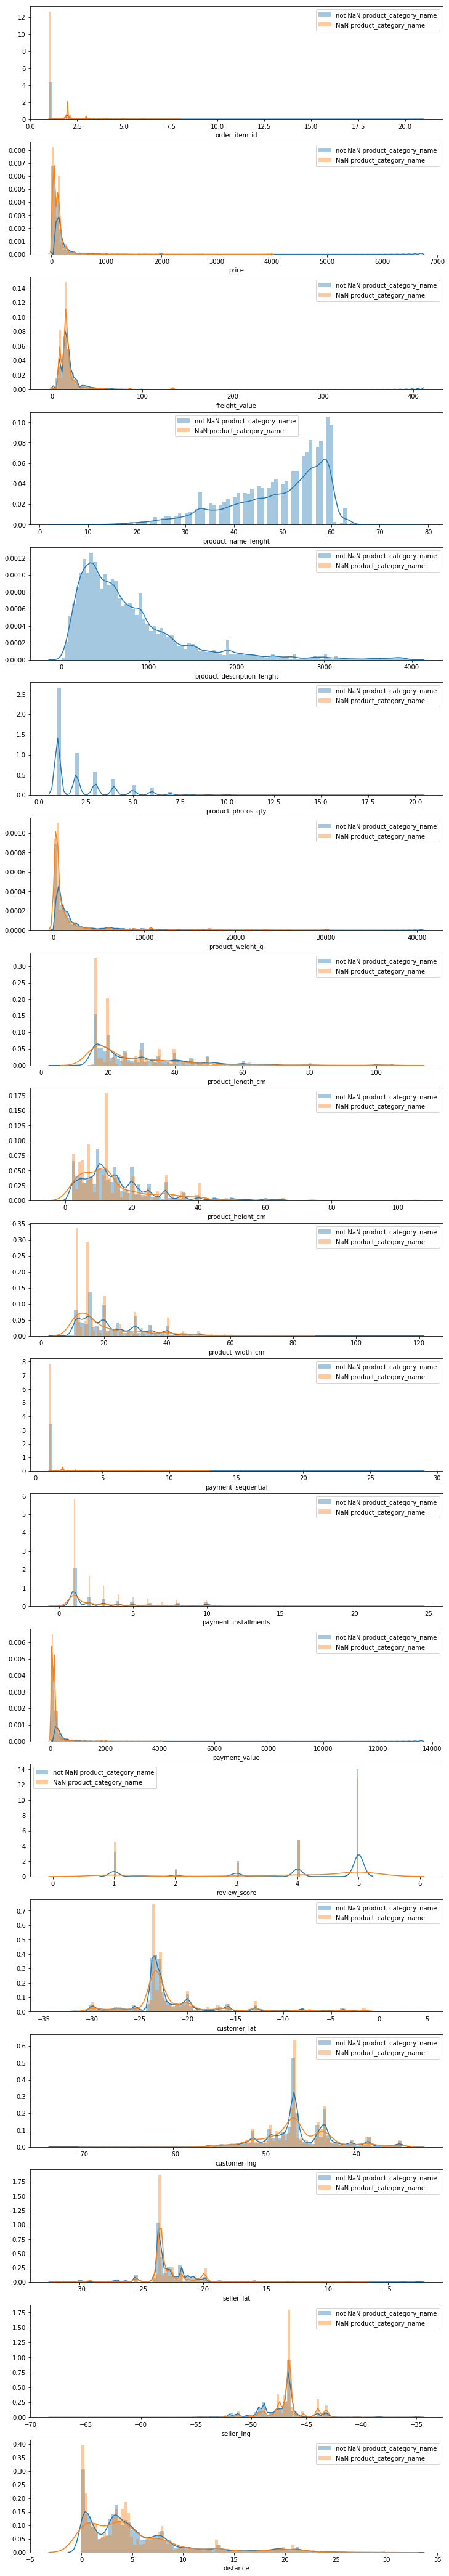

In [0]:
num_cols=dfMerged.select_dtypes('number').columns
fig,axes=plt.subplots(len(num_cols),1,figsize=(12,4*len(num_cols)))
for col,ax in zip(num_cols,axes):
    sns.distplot(dfMerged[dfMerged['product_category_name'].notnull()][col].dropna(),ax=ax,bins=100)
    sns.distplot(dfMerged[dfMerged['product_category_name'].isna()][col].dropna(),ax=ax,bins=100)
    ax.legend(['not NaN product_category_name','NaN product_category_name'])

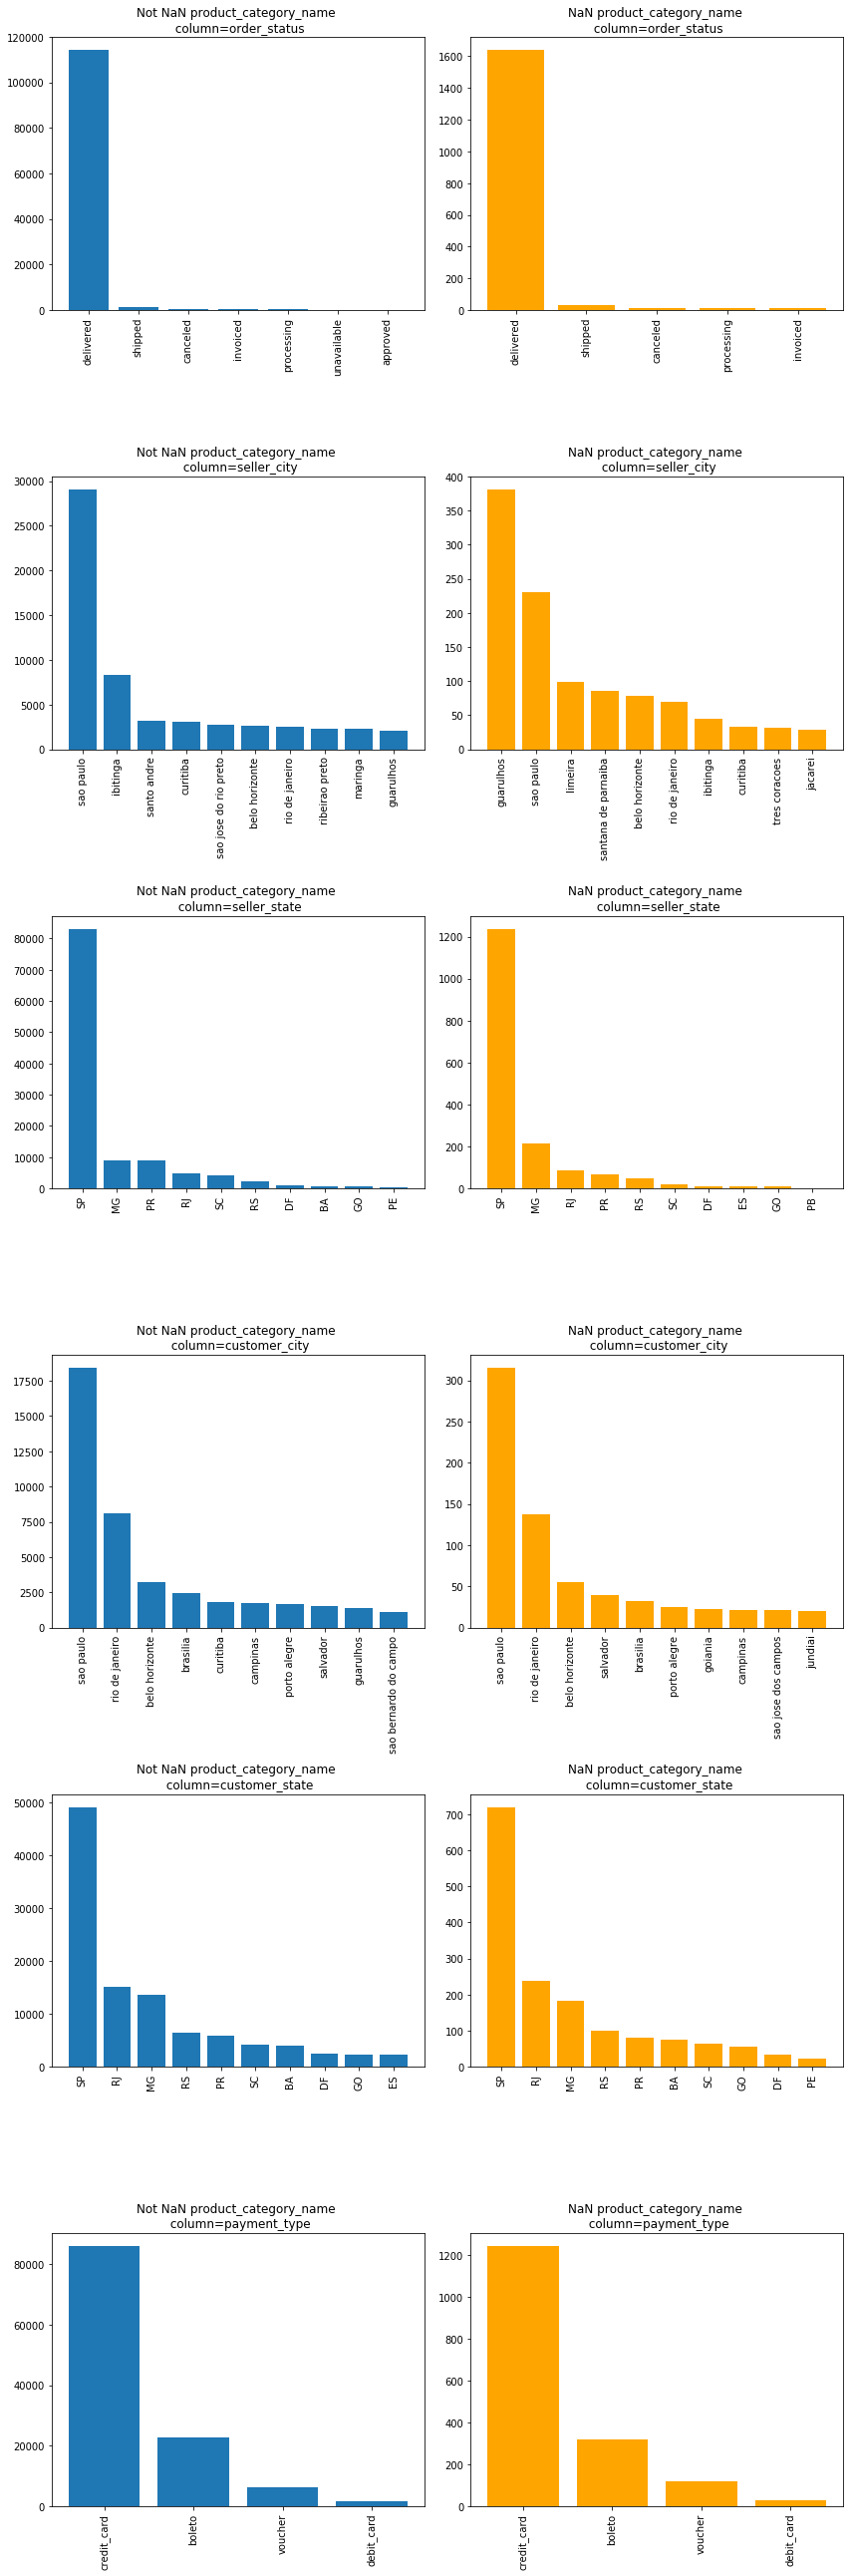

In [0]:
cat_cols=['order_status','seller_city','seller_state','customer_city','customer_state','payment_type']
fig,axes=plt.subplots(len(cat_cols),2,figsize=(12,len(cat_cols)*6))
for col,ax in zip(cat_cols,axes):
    not_na=dfMerged[dfMerged['product_category_name'].notnull()][col].value_counts().head(10)
    is_na=dfMerged[dfMerged['product_category_name'].isna()][col].value_counts().head(10)
    ax[0].bar(not_na.index,not_na)
    ax[0].tick_params(axis='x', labelrotation=90)
    ax[0].set_title(f'Not NaN product_category_name \n column={col}')
    ax[1].bar(is_na.index,is_na,color='orange')
    ax[1].tick_params(axis='x', labelrotation=90)
    ax[1].set_title(f'NaN product_category_name \n column={col}')
plt.tight_layout()

In [0]:
ser=dfMerged['payment_value']-dfMerged['price']-dfMerged['freight_value']
ser.describe()

count    1.183150e+05
mean     3.189160e+01
std      1.790215e+02
min     -3.899000e+03
25%     -3.552714e-15
50%      8.881784e-16
75%      1.243450e-14
max      1.195607e+04
dtype: float64

In [0]:
ser[ser<0].describe()

count    4.163200e+04
mean    -1.640669e+01
std      7.319052e+01
min     -3.899000e+03
25%     -2.131628e-14
50%     -7.105427e-15
75%     -3.552714e-15
max     -8.881784e-16
dtype: float64

In [0]:
def compare(df,col,condition_1,condition_2,n_1=None,n_2=None):
    if n_1==None or n_2==None:
        suffixes=('_x', '_y')
    else:
        suffixes=(f'_{n_1}',f'_{n_2}')
    comparison=pd.merge(df[condition_1][col].value_counts(normalize=True),df[condition_2][col].value_counts(normalize=True),left_index=True,right_index=True,suffixes=suffixes)
    comparison['difference']=abs(comparison.iloc[:,0]-comparison.iloc[:,1])
    comparison=round(comparison*100,3)
    comparison=pd.merge(comparison,df.rename(columns={col:'Value Counts'})['Value Counts'].value_counts(),left_index=True,right_index=True)
    for col in comparison.columns:
        if col in comparison.columns[:2]:
            comparison.loc['Sum',col]=round(comparison[col].sum(),0)
        else:
            comparison.loc['Sum',col]=round(comparison[col].sum(),3)
        comparison.loc['Average',col]=round(comparison[col].mean(),3)
    return comparison

In [0]:
compare(dfMerged,'product_category_name',ser<0,ser>=0,'sales loss','sales profit')

product_category_name_sales loss  \
bed bath table                                                     11.198   
health beauty                                                       7.976   
sports leisure                                                      7.879   
furniture decor                                                     6.475   
watches gifts                                                       6.395   
computers accessories                                               6.317   
housewares                                                          5.946   
cool stuff                                                          4.621   
toys                                                                4.221   
auto                                                                3.980   
perfumery                                                           3.709   
baby                                                                3.205   
garden tools                                                        3.124   
telephony                                                           2.854   
stationery                                                          2.552   
electronics                                                         1.918   
pet shop                                                            1.855   
fashion bags accessories                                            1.703   
office furniture                                                    1.306   
luggage accessories                                                 1.296   
consoles games                                                      0.941   
home appliances                                                     0.751   
musical instruments                                                 0.712   
construction tools construction                                     0.690   
small appliances                                                    0.646   
home confort                                                        0.575   
home construction                                                   0.480   
furniture living room                                               0.434   
audio                                                               0.422   
food                                                                0.397   
books general interest                                              0.390   
home appliances 2                                                   0.336   
computers                                                           0.317   
kitchen dining laundry garden furniture                             0.302   
market place                                                        0.288   
agro industry and commerce                                          0.280   
fashion shoes                                                       0.229   
industry commerce and business                                      0.227   
drinks                                                              0.217   
books technical                                                     0.214   
construction tools lights                                           0.207   
air conditioning                                                    0.190   
costruction tools garden                                            0.188   
food drink                                                          0.180   
fixed telephony                                                     0.175   
fashion underwear beach                                             0.166   
construction tools safety                                           0.163   
art                                                                 0.156   
fashion male clothing                                               0.129   
furniture bedroom                                                   0.124   
christmas supplies                                                  0.117   
tablets printing image               

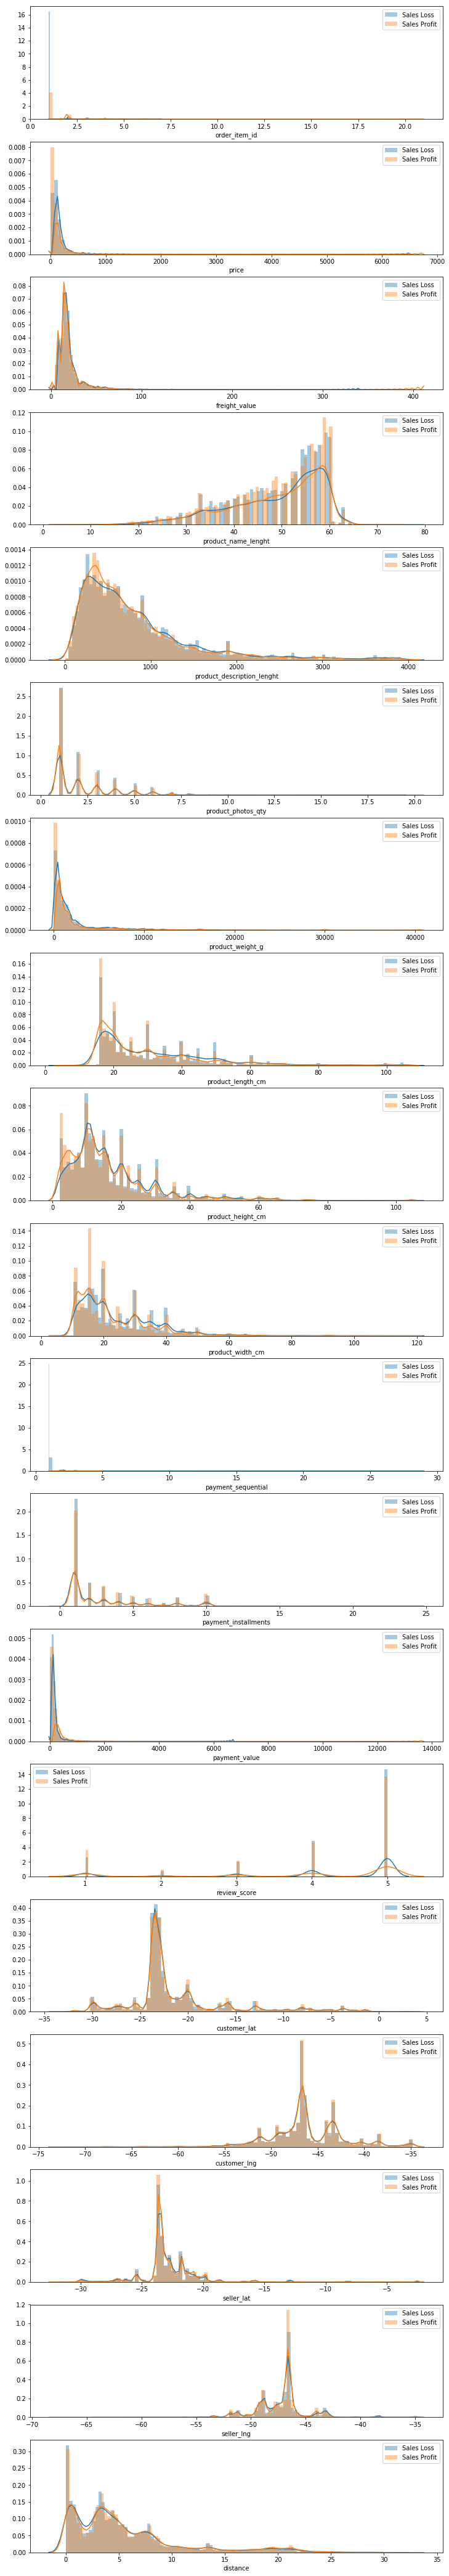

In [0]:
fig,axes=plt.subplots(len(num_cols),1,figsize=(12,4*len(num_cols)))
for col,ax in zip(num_cols,axes):
    sns.distplot(dfMerged[ser<0][col].dropna(),ax=ax,bins=100)
    sns.distplot(dfMerged[ser>=0][col].dropna(),ax=ax,bins=100)
    ax.legend(['Sales Loss','Sales Profit'])

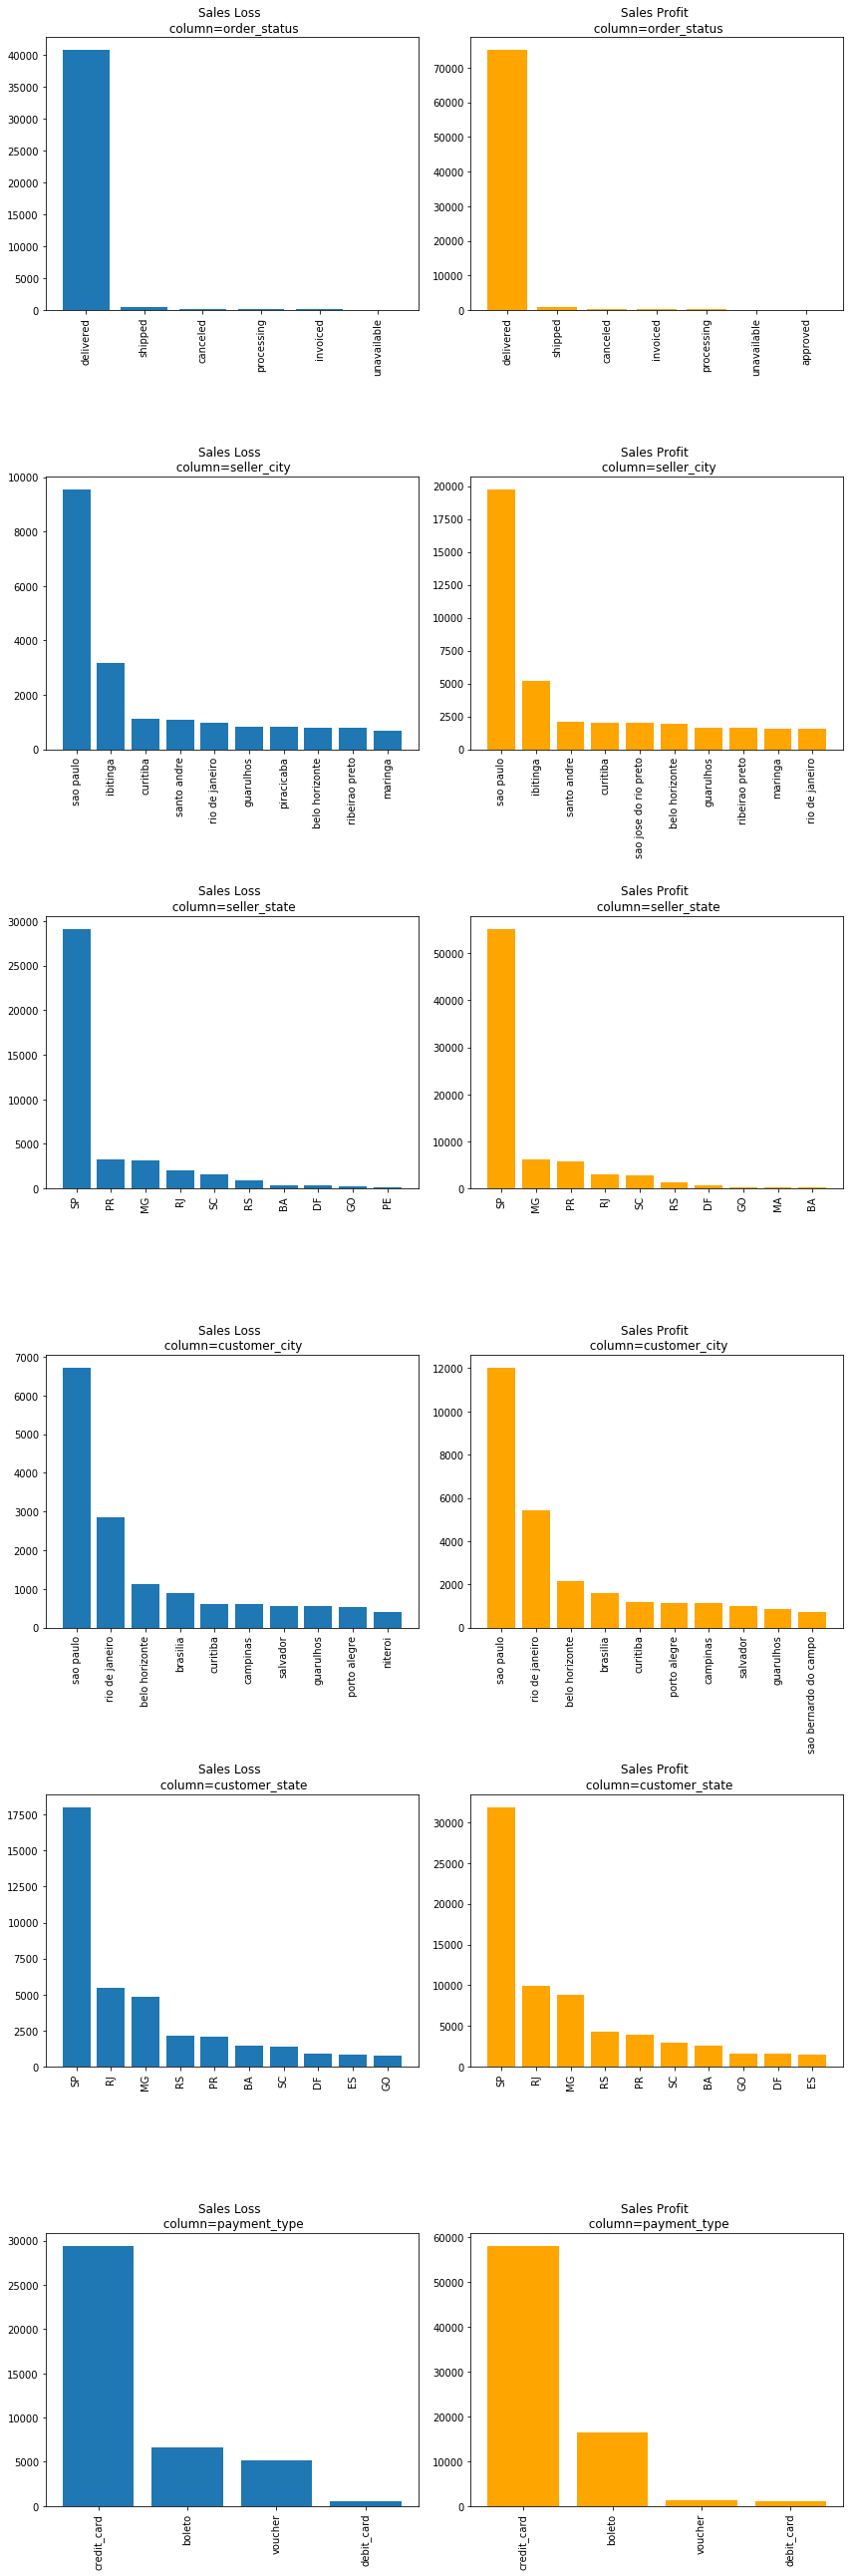

In [0]:
fig,axes=plt.subplots(len(cat_cols),2,figsize=(12,len(cat_cols)*6))
for col,ax in zip(cat_cols,axes):
    not_na=dfMerged[ser<0][col].value_counts().head(10)
    is_na=dfMerged[ser>=0][col].value_counts().head(10)
    ax[0].bar(not_na.index,not_na)
    ax[0].tick_params(axis='x', labelrotation=90)
    ax[0].set_title(f'Sales Loss \n column={col}')
    ax[1].bar(is_na.index,is_na,color='orange')
    ax[1].tick_params(axis='x', labelrotation=90)
    ax[1].set_title(f'Sales Profit \n column={col}')
plt.tight_layout()

In [0]:
compare(dfMerged,'payment_type',ser<0,ser>=0,'sales loss','sales profit')

payment_type_sales loss  payment_type_sales profit  difference  \
credit_card                   70.547                     75.500       4.954   
boleto                        15.800                     21.439       5.639   
voucher                       12.339                      1.558      10.781   
debit_card                     1.314                      1.502       0.188   
Sum                          100.000                    100.000      21.562   
Average                       40.000                     40.000       8.625   

             Value Counts  
credit_card       87266.0  
boleto            23018.0  
voucher            6332.0  
debit_card         1699.0  
Sum              118315.0  
Average           47326.0

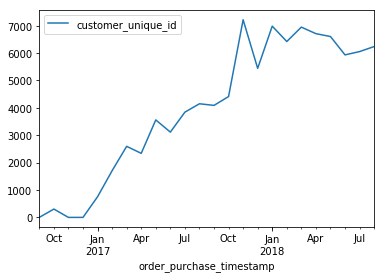

In [0]:
gb=dfMerged[['customer_unique_id','order_purchase_timestamp']].groupby('customer_unique_id').min()
gb.reset_index().set_index('order_purchase_timestamp').resample('M').count().plot.line()

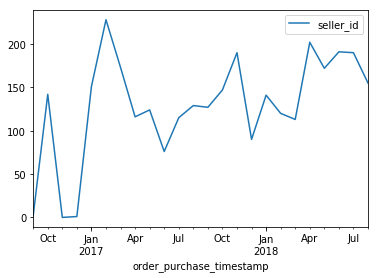

In [0]:
gb=dfMerged[['seller_id','order_purchase_timestamp']].groupby('seller_id').min()
gb.reset_index().set_index('order_purchase_timestamp').resample('M').count().plot.line()

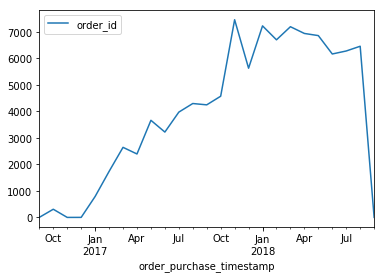

In [0]:
gb=dfMerged[['order_id','order_purchase_timestamp']].groupby('order_id').min()
gb.reset_index().set_index('order_purchase_timestamp').resample('M').count().plot.line()

In [0]:
dfMerged.sort_values('shipping_limit_date',ascending=False).head()

order_id                       customer_id  \
102704  c2bb89b5c1dd978d507284be78a04cb2  6357fffb5704244d552615bbfcea1442   
102705  c2bb89b5c1dd978d507284be78a04cb2  6357fffb5704244d552615bbfcea1442   
42922   13bdf405f961a6deec817d817f5c6624  b279a1d441c73c1974d7a63618855aa0   
65820   9c94a4ea2f7876660fa6f1b59b69c8e6  22e922696a7d1ab9a19c6b702fedc387   
66376   3b61aab5de69abc1731138bd104a777f  8e29c6e9c795eda30cf7f47244720132   

       order_status order_purchase_timestamp   order_approved_at  \
102704    delivered      2017-05-23 22:28:36 2017-05-24 22:35:08   
102705    delivered      2017-05-23 22:28:36 2017-05-24 22:35:08   
42922      canceled      2017-03-16 02:30:51 2017-03-16 02:30:51   
65820       shipped      2017-03-14 19:23:22 2017-03-14 19:23:22   
66376     delivered      2018-08-25 20:59:18 2018-08-25 21:10:15   

       order_delivered_carrier_date order_delivered_customer_date  \
102704          2017-05-29 02:03:28           2017-06-09 13:35:54   
102705          2017-05-29 02:03:28           2017-06-09 13:35:54   
42922                           NaT                           NaT   
65820           2017-03-16 14:31:15                           NaT   
66376           2018-08-28 15:05:00           2018-08-30 16:47:53   

       order_estimated_delivery_date  order_item_id  \
102704                    2017-10-11              1   
102705                    2017-10-11              2   
42922                     2017-08-08              1   
65820                     2017-08-04              1   
66376                     2018-09-21              1   

                              product_id                         seller_id  \
102704  87b92e06b320e803d334ac23966c80b1  7a241947449cc45dbfda4f9d0798d9d0   
102705  87b92e06b320e803d334ac23966c80b1  7a241947449cc45dbfda4f9d0798d9d0   
42922   96ea060e41bdecc64e2de00b97068975  7a241947449cc45dbfda4f9d0798d9d0   
65820   282b126b2354516c5f400154398f616d  7a241947449cc45dbfda4f9d0798d9d0   
66376   6aa063e063f2ab982b471e58afe06d72  610f72e407cdd7caaa2f8167b0163fd8   

       shipping_limit_date   price  freight_value seller_zip_code_prefix  \
102704 2020-04-09 22:35:08   99.99          61.44                  37590   
102705 2020-04-09 22:35:08   99.99          61.44                  37590   
42922  2020-02-05 03:30:51   69.99          14.66                  37590   
65820  2020-02-03 20:23:22   75.99          14.70                  37590   
66376  2018-09-18 21:10:15  999.99          24.77                  01201   

       seller_city seller_state product_category_name  product_name_lenght  \
102704   jacutinga           MG            housewares                 58.0   
102705   jacutinga           MG            housewares                 58.0   
42922    jacutinga           MG            housewares                 45.0   
65820    jacutinga           MG            housewares                 48.0   
66376    sao paulo           SP        bed bath table                 57.0   

        product_description_lenght  product_photos_qty  product_weight_g  \
102704                       914.0                 5.0           15000.0   
102705                       914.0                 5.0           15000.0   
42922                       1875.0                 4.0            5150.0   
65820                       2396.0                 2.0            3700.0   
66376                        126.0                 2.0            9000.0   

        product_length_cm  product_height_cm  product_width_cm  \
102704               35.0               30.0              25.0   
102705               35.0               30.0              25.0   
42922                70.0                9.0              40.0   
65820                20.0               20.0              20.0   
66376                25.0               55.0              50.0   

                      customer_unique_id customer_zip_code_prefix  \
102704  44b6bbfea26596437062a38c8e6bcec1                    15040   
102705  44b6bbfea2659

In [0]:
dfMerged[dfMerged['seller_city']=='jacutinga'].sort_values('shipping_limit_date',ascending=False)

order_id                       customer_id  \
102705  c2bb89b5c1dd978d507284be78a04cb2  6357fffb5704244d552615bbfcea1442   
102704  c2bb89b5c1dd978d507284be78a04cb2  6357fffb5704244d552615bbfcea1442   
42922   13bdf405f961a6deec817d817f5c6624  b279a1d441c73c1974d7a63618855aa0   
65820   9c94a4ea2f7876660fa6f1b59b69c8e6  22e922696a7d1ab9a19c6b702fedc387   
97980   67d06af97696c95df2bb26acf82db637  d3ddbbd220a088a3e353cd270c184e60   
28682   4ed868229ad01b5686124edd1f82b18b  3826c69b59a924f799f03ee725391b04   
47048   aceb0ac9c2d49926c0eadc1510a3ff53  6bef26f5ffada3596c2e922c09a648bb   
38619   a251945eec0cc0482667c716eab7c09c  9ec9cb2a44ecdd3fd0c412cb3d331c03   
40075   b7daca2d24a93ab9351485e0bdcbb7e6  002d597546b2cf44428232c9f237f873   
107148  3ad3f75989908136712eba79927a805c  454e6236785cc7789bcdb331e7499c4b   
84307   ffebd80e3291e811c308365936897efd  050309b91cc5e04e68841938e7984aaf   
55100   2e1b96bb2d8b0ca7e4a6c3d0c15d68a3  7aa6b791c1e47633122b949ed9d51b83   
106280  7d1815eb5b915c108c7cd16f13c41a37  5fb8085de28030617a63b8c24dcb3ab9   
61668   2ed33375a2cee6fc56528d1753af71de  7894c81ead8ddaa0d78631085bb3ec69   
78262   aa62e67d7dbefd7e1331d5975f61a404  e6b1b2e9d776e6657e9b243fcc56502e   
91027   5545b19e008b4a2989c495761e53456a  9c0e68320c244cf91a86cfc2602ed325   
61859   f36770932c1481e3aab9eced257e50b6  899cdc1395d9d42d165d8935d7bbc7f6   
103976  1e12bd2ecc7b4ed9cb562be4e64cbd7f  d4dd8c03527a45f25fffb55a071fdf21   
30013   72a29a34308d7f62487412864e45db51  1a19124c6250a1dd852aed6824b9bac5   
65702   d28b6e04966e316ea1b0bda721d70144  425f6c6bec6f98b846413490336033bf   
76832   bbcdf6eade27ba117835cb683a80ce09  bf84e9b726894ba53de7227af764823a   
89339   54c2fa26d524b90f034358bd9d333207  4cedc70e398faa2ae5e711c53c31d7b4   
66365   6ed6b87e6f8afe27921e761104771bbd  ae5889fe15b781429771c232b8b81d59   
107375  969721cf60a5aac05ee9fd4375fd9934  35e44b2134df14f2551b361aecdc47ce   
116397  efd5eba320d140f8659440d74a81fc90  08c57266985b0f9bda94720351457be4   
61765   bd6a4be98625711812fdabccdcdff8ca  31e34659933a639fd1d656924e76cd35   
44197   bdf2b8212af123f029e70c1036e2895e  579e6c506a2eb334f56576b996e356c2   
117592  cf528e0d99cf05154203f3ef20caac76  33245095f70ea953afeb2b688c2ad210   
102112  884f74c6b1d625c13e1ef12d7314a2a9  b95c303652bfe9fa2d4851ec82983c2a   
22485   bb01b380d61941aa0f175614b3e62dc6  8d157f0f4712e2106c44d2bc69e23567   
58237   b5cded175dda03c8360eb5d652b931e1  3caac0647292a8ce09b6ab64320754d1   
49448   1676852853bb81a2a74bceb23c87ea44  7d0ff11552c535ce8179ab49b5f0838b   
3614    862cca64868df4c3a3f0058a93aef465  58f2a48696b2cf8da50fcb21f8512c14   
112272  768cf7b525325877d87127d98b19c7d9  744a5734ea69601b880719ac40a5a50f   
39370   3e290444f5680a0f8a95b7d87980a358  f072965e658fe6c9591cc88d5b6cd9fe   
69763   d80776183a62be9d9a9eb2dd9b8e92bb  80fb4591a82a055c4f9c11944ab2abbb   
8716    930299b3cc193996df76f2ba8c82a916  e1c05be92c14fdfdf526f81df3d5066f   
35541   10bc271bab7798c98b6889a54e45fc8f  08ab4c257d3664e4e28edf27010616de   
3383    6942e86d33b375b95195dda92c2f603d  d6cdfeca7b382005c0afaff5ee4c24cd   
27612   c52c7fbe316b5b9d549e8a25206b8a1f  88324c93ce11436ae046563bf0da285c   
27619   c52c7fbe316b5b9d549e8a25206b8a1f  88324c93ce11436ae046563bf0da285c   
27611   c52c7fbe316b5b9d549e8a25206b8a1f  88324c93ce11436ae046563bf0da285c   
27613   c52c7fbe316b5b9d549e8a25206b8a1f  88324c93ce11436ae046563bf0da285c   
27614   c52c7fbe316b5b9d549e8a25206b8a1f  88324c93ce11436ae046563bf0da285c   
27615   c52c7fbe316b5b9d549e8a25206b8a1f  88324c93ce11436ae046563bf0da285c   
27616   c52c7fbe316b5b9d549e8a25206b8a1f  88324c93ce11436ae046563bf0da285c   
27617   c52c7fbe316b5b9d549e8a25206b8a1f  88324c93ce11436ae046563bf0da285c   
27618   c52c7fbe316b5b9d549e8a25206b8a1f  88324c93ce11436ae046563bf0da285c   
51189   b856177bc1f9aa86b04e068c301990ed  00d1bd043022c327bc464ded6b731f4a   
82088   c57fbb30efb2a0170ccc3db897839462  a340a31c375e325235ebea62465f3f24   
82087   c57fbb30efb2a0170ccc3db897839462  a340a31c375e

In [0]:
def pivot(df,index,column,n=25):
    val_cols=df[column].value_counts().head(n)
    val_idx=df[index].value_counts().head(n)
    cols=val_cols.index
    idx=val_idx.index
    pvt=pd.DataFrame([['-',*list(val_cols)]],['TOTAL'],['TOTAL',*[f'{column}#{num+1}' for num in range(n)]])
    for num_1,i in enumerate(idx):
        pvt.loc[f'{index}#{num_1+1}','TOTAL']=val_idx[i]
        for num_2,c in enumerate(cols):
            pvt.loc[f'{index}#{num_1+1}',f'{column}#{num_2+1}']=df[(df[index]==i) & (df[column]==c)].count().max()
    return pvt

In [0]:
pivot(dfMerged,'product_id','seller_id')

TOTAL  seller_id#1  seller_id#2  seller_id#3  seller_id#4  \
TOTAL             -       2155.0       2130.0       2017.0       1893.0   
product_id#1    536          0.0          0.0          0.0          0.0   
product_id#2    528        522.0          0.0          0.0          0.0   
product_id#3    508          0.0          0.0        508.0          0.0   
product_id#4    406          0.0          0.0        406.0          0.0   
product_id#5    398          0.0          0.0        398.0          0.0   
product_id#6    391          0.0          0.0        391.0          0.0   
product_id#7    357          0.0          0.0          0.0          0.0   
product_id#8    327          0.0          0.0          0.0          0.0   
product_id#9    295          0.0          0.0          0.0        295.0   
product_id#10   278          0.0          0.0          0.0          0.0   
product_id#11   275          0.0          0.0          0.0        275.0   
product_id#12   242          0.0          0.0          0.0        242.0   
product_id#13   228          0.0          0.0          0.0          0.0   
product_id#14   210          0.0          0.0          0.0          0.0   
product_id#15   202          0.0          0.0          0.0          0.0   
product_id#16   197          0.0          0.0          0.0          0.0   
product_id#17   192          0.0          0.0          0.0          0.0   
product_id#18   189        188.0          0.0          0.0          0.0   
product_id#19   185          0.0          0.0          0.0          0.0   
product_id#20   181          0.0          0.0          0.0          0.0   
product_id#21   164          0.0        164.0          0.0          0.0   
product_id#22   164          0.0          0.0          0.0          0.0   
product_id#23   163          0.0          0.0          0.0          0.0   
product_id#24   159          0.0          0.0          0.0          0.0   
product_id#25   157          0.0          0.0          0.0          0.0   

               seller_id#5  seller_id#6  seller_id#7  seller_id#8  \
TOTAL               1662.0       1530.0       1477.0       1463.0   
product_id#1           0.0        536.0          0.0          0.0   
product_id#2           0.0          0.0          0.0          0.0   
product_id#3           0.0          0.0          0.0          0.0   
product_id#4           0.0          0.0          0.0          0.0   
product_id#5           0.0          0.0          0.0          0.0   
product_id#6           0.0          0.0          0.0          0.0   
product_id#7           0.0          0.0          0.0          0.0   
product_id#8           0.0          0.0          0.0          0.0   
product_id#9           0.0          0.0          0.0          0.0   
product_id#10          0.0          0.0          0.0          0.0   
product_id#11          0.0          0.0          0.0          0.0   
product_id#12          0.0          0.0          0.0          0.0   
product_id#13          0.0          0.0          0.0          0.0   
product_id#14          0.0          0.0          0.0          0.0   
product_id#15          0.0          0.0          0.0          0.0   
product_id#16          0.0          0.0          0.0          0.0   
product_id#17          0.0          0.0          0.0          0.0   
product_id#18          0.0          0.0          0.0          0.0   
product_id#19          0.0          0.0          0.0          0.0   
product_id#20          0.0          0.0        181.0          0.0   
product_id#21          0.0          0.0          0.0          0.0   
product_id#22          0.0          0.0          0.0          0.0   
product_id#23          0.0          0.0          0.0          0.0   
product_id#24          0.0          0.0          0.0          0.0   
product_id#25          0.0          0.0          0.0          0.0   

               seller_id#9  seller_id#10  seller_id#11  seller_id#12  \
TOTAL               1245.0        1240.0        1205

In [0]:
pivot(dfMerged,'product_id','customer_unique_id')

TOTAL  customer_unique_id#1  customer_unique_id#2  \
TOTAL             -                  75.0                  38.0   
product_id#1    536                   0.0                   0.0   
product_id#2    528                   0.0                   0.0   
product_id#3    508                   0.0                   0.0   
product_id#4    406                   0.0                   0.0   
product_id#5    398                   0.0                   0.0   
product_id#6    391                   0.0                   0.0   
product_id#7    357                   0.0                   0.0   
product_id#8    327                   0.0                   0.0   
product_id#9    295                   0.0                   0.0   
product_id#10   278                   0.0                   0.0   
product_id#11   275                   0.0                   0.0   
product_id#12   242                   0.0                   0.0   
product_id#13   228                   0.0                   0.0   
product_id#14   210                   0.0                   0.0   
product_id#15   202                   0.0                   0.0   
product_id#16   197                   0.0                   0.0   
product_id#17   192                   0.0                   0.0   
product_id#18   189                   0.0                   0.0   
product_id#19   185                   0.0                   0.0   
product_id#20   181                   0.0                   0.0   
product_id#21   164                   0.0                   0.0   
product_id#22   164                   0.0                   0.0   
product_id#23   163                   0.0                   0.0   
product_id#24   159                   0.0                   0.0   
product_id#25   157                   0.0                   0.0   

               customer_unique_id#3  customer_unique_id#4  \
TOTAL                          35.0                  29.0   
product_id#1                    0.0                   0.0   
product_id#2                    0.0                   0.0   
product_id#3                    0.0                   0.0   
product_id#4                    0.0                   0.0   
product_id#5                    0.0                   0.0   
product_id#6                    0.0                   0.0   
product_id#7                    0.0                   0.0   
product_id#8                    0.0                   0.0   
product_id#9                    0.0                   0.0   
product_id#10                   0.0                   0.0   
product_id#11                   0.0                   0.0   
product_id#12                   0.0                   0.0   
product_id#13                   0.0                   0.0   
product_id#14                   0.0                   0.0   
product_id#15                   0.0                   0.0   
product_id#16                   0.0                   0.0   
product_id#17                   0.0                   0.0   
product_id#18                   0.0                   0.0   
product_id#19                   0.0                   0.0   
product_id#20                   0.0                   0.0   
product_id#21                   0.0                   0.0   
product_id#22                   0.0                   0.0   
product_id#23                   0.0                   0.0   
product_id#24                   0.0                   0.0   
product_id#25                   0.0                   0.0   

               customer_unique_id#5  customer_unique_id#6  \
TOTAL                          26.0                  24.0   
product_id#1                    0.0                   0.0   
product_id#2                    0.0                   0.0   
product_id#3                    0.0                   0.0   
product_id#4                    0.0                   0.0   
product_id#5                    0.0                   0.0   
product_id#6                    0.0                   0.0   
product_id#7                    0.0                  12.0   
product

In [0]:
dfMerged.groupby(['product_id','customer_id']).count().iloc[:,0].sort_values(ascending=False).head(20)

product_id                        customer_id                     
ebf9bc6cd600eadd681384e3116fda85  270c23a11d024a44c896d1894b261a83    42
0554911df28fda9fd668ce5ba5949695  13aa59158da63ba0e93ec6ac2c07aacb    38
1aecdb5fa3add74e385f25c6c527a462  9af2372a1e49340278e7c1ef8d749f34    29
8d37ee446981d3790967d0268d6cfc81  92cd3ec6e2d643d4ebd0e3d6238f69e2    26
11250b0d4b709fee92441c5f34122aed  63b964e79dee32a3587651701a2b8dbf    24
0449db5eede617c5fd413071d582f038  6ee2f17e3b6c33d6a9557f280edd2925    24
eea3e07f864a0a1389726d8a5f31c3f6  2ba91e12e5e4c9f56b82b86d9031d329    24
4e53a453045707bbc5febcf5f32097ac  d22f25a9fadfb1abbc2e29395b1239f4    24
bdc3291ab242ec1effc8eb0987850268  b246eeed30b362c09d867b9e598bee51    22
5ddab10d5e0a23acb99acf56b62b3276  270c23a11d024a44c896d1894b261a83    21
991d9793febfe022d5db970595a99008  5e0f7317756669ff7b384444dbb81fa3    21
ee3d532c8a438679776d222e997606b3  be1b70680b9f9694d8c70f41fa3dc92b    20
9571759451b1d780ee7c15012ea109d4  bd5d39761aa56689a265d95

In [0]:
pivot(dfMerged,'customer_unique_id','seller_id')

TOTAL  seller_id#1  seller_id#2  seller_id#3  \
TOTAL                     -       2155.0       2130.0       2017.0   
customer_unique_id#1     75          0.0          0.0          0.0   
customer_unique_id#2     38          0.0          0.0          0.0   
customer_unique_id#3     35          0.0          0.0          0.0   
customer_unique_id#4     29          0.0          0.0          0.0   
customer_unique_id#5     26          0.0          0.0          0.0   
customer_unique_id#6     24          0.0          0.0          0.0   
customer_unique_id#7     24          0.0          0.0          0.0   
customer_unique_id#8     24          0.0          0.0          0.0   
customer_unique_id#9     24          0.0          0.0          0.0   
customer_unique_id#10    24          0.0          0.0          0.0   
customer_unique_id#11    24          0.0          0.0          0.0   
customer_unique_id#12    24          0.0          0.0          0.0   
customer_unique_id#13    22          0.0          0.0          0.0   
customer_unique_id#14    21          0.0          0.0          0.0   
customer_unique_id#15    21          0.0          0.0          0.0   
customer_unique_id#16    21          0.0          0.0          0.0   
customer_unique_id#17    20          0.0          0.0          0.0   
customer_unique_id#18    20          0.0          0.0          0.0   
customer_unique_id#19    20          0.0          0.0          0.0   
customer_unique_id#20    20          0.0          0.0          0.0   
customer_unique_id#21    19         19.0          0.0          0.0   
customer_unique_id#22    18          0.0          0.0          0.0   
customer_unique_id#23    16          0.0          0.0          0.0   
customer_unique_id#24    16          0.0          0.0          0.0   
customer_unique_id#25    15          0.0          0.0          0.0   

                       seller_id#4  seller_id#5  seller_id#6  seller_id#7  \
TOTAL                       1893.0       1662.0       1530.0       1477.0   
customer_unique_id#1           0.0          0.0          0.0          0.0   
customer_unique_id#2           0.0          0.0          0.0          0.0   
customer_unique_id#3           0.0          0.0          0.0          0.0   
customer_unique_id#4           0.0          0.0          0.0          0.0   
customer_unique_id#5           0.0          0.0          0.0          0.0   
customer_unique_id#6           0.0          0.0          0.0          0.0   
customer_unique_id#7           0.0          0.0          0.0          0.0   
customer_unique_id#8           0.0          0.0          0.0          0.0   
customer_unique_id#9           0.0          0.0          0.0          0.0   
customer_unique_id#10          0.0          0.0          0.0          0.0   
customer_unique_id#11          0.0          0.0          0.0          0.0   
customer_unique_id#12          0.0          0.0          0.0          0.0   
customer_unique_id#13          0.0          0.0          0.0          0.0   
customer_unique_id#14          0.0          0.0          0.0          0.0   
customer_unique_id#15          0.0          0.0          0.0          0.0   
customer_unique_id#16          0.0          0.0          0.0          0.0   
customer_unique_id#17          0.0          0.0          0.0          0.0   
customer_unique_id#18          0.0          0.0          0.0          0.0   
customer_unique_id#19          0.0          0.0          0.0          0.0   
customer_unique_id#20          0.0          0.0          0.0          0.0   
customer_unique_id#21          0.0          0.0          0.0          0.0   
customer_unique_id#22          0.0          0.0          0.0          0.0   
customer_unique_id#23          0.0          0.0          0.0          0.0   
customer_unique_id#24          0.0          0.0          0.0          0.0   
customer_unique_id#25          0.0          0.0          0.0          0.0   

                       seller_id#8  seller_id#9  se

In [0]:
dfMerged.groupby(['seller_id','customer_id']).count().iloc[:,0].sort_values(ascending=False).head(20)

seller_id                         customer_id                     
822166ed1e47908f7cfb49946d03c726  270c23a11d024a44c896d1894b261a83    42
7c67e1448b00f6e969d365cea6b010ab  13aa59158da63ba0e93ec6ac2c07aacb    38
06532f10282704ef4c69168b914b77be  9af2372a1e49340278e7c1ef8d749f34    29
1900267e848ceeba8fa32d80c1a5f5a8  92cd3ec6e2d643d4ebd0e3d6238f69e2    26
e59aa562b9f8076dd550fcddf0e73491  63b964e79dee32a3587651701a2b8dbf    24
21e83881401b92b49fb09a16d3852291  6ee2f17e3b6c33d6a9557f280edd2925    24
9f505651f4a6abe901a56cdc21508025  d22f25a9fadfb1abbc2e29395b1239f4    24
3c7c4a49ec3c6550809089c6a2ca9370  2ba91e12e5e4c9f56b82b86d9031d329    24
dbd66278cbfe1aa1000f90a217ca4695  b246eeed30b362c09d867b9e598bee51    22
9140bd1d9de28b197dce077bdd687438  5e0f7317756669ff7b384444dbb81fa3    21
3d0cd21d41671c46f82cd11176bf7277  270c23a11d024a44c896d1894b261a83    21
2709af9587499e95e803a6498a5a56e9  fc3d1daec319d62d49bfb5e1f83123e9    21
ce27a3cc3c8cc1ea79d11e561e9bebb6  bd5d39761aa56689a265d95

In [0]:
dfMerged.groupby(['product_id','seller_id','customer_id']).count().iloc[:,0].sort_values(ascending=False).head(20)

product_id                        seller_id                         customer_id                     
ebf9bc6cd600eadd681384e3116fda85  822166ed1e47908f7cfb49946d03c726  270c23a11d024a44c896d1894b261a83    42
0554911df28fda9fd668ce5ba5949695  7c67e1448b00f6e969d365cea6b010ab  13aa59158da63ba0e93ec6ac2c07aacb    38
1aecdb5fa3add74e385f25c6c527a462  06532f10282704ef4c69168b914b77be  9af2372a1e49340278e7c1ef8d749f34    29
8d37ee446981d3790967d0268d6cfc81  1900267e848ceeba8fa32d80c1a5f5a8  92cd3ec6e2d643d4ebd0e3d6238f69e2    26
eea3e07f864a0a1389726d8a5f31c3f6  3c7c4a49ec3c6550809089c6a2ca9370  2ba91e12e5e4c9f56b82b86d9031d329    24
0449db5eede617c5fd413071d582f038  21e83881401b92b49fb09a16d3852291  6ee2f17e3b6c33d6a9557f280edd2925    24
4e53a453045707bbc5febcf5f32097ac  9f505651f4a6abe901a56cdc21508025  d22f25a9fadfb1abbc2e29395b1239f4    24
11250b0d4b709fee92441c5f34122aed  e59aa562b9f8076dd550fcddf0e73491  63b964e79dee32a3587651701a2b8dbf    24
bdc3291ab242ec1effc8eb0987850268  dbd66278c

In [0]:
dfMerged[(dfMerged['product_id']=='ebf9bc6cd600eadd681384e3116fda85')].drop_duplicates().describe(include='all').T

count unique                               top  \
order_id                         44      2  895ab968e7bb0d5659d16cd74cd1650c   
customer_id                      44      2  270c23a11d024a44c896d1894b261a83   
order_status                     44      1                         delivered   
order_purchase_timestamp         44      2               2017-08-08 20:26:31   
order_approved_at                44      2               2017-08-08 20:43:31   
order_delivered_carrier_date     44      2               2017-08-10 11:58:14   
order_delivered_customer_date    44      2               2017-08-14 12:46:18   
order_estimated_delivery_date    44      2               2017-08-30 00:00:00   
order_item_id                    44    NaN                               NaN   
product_id                       44      1  ebf9bc6cd600eadd681384e3116fda85   
seller_id                        44      1  822166ed1e47908f7cfb49946d03c726   
shipping_limit_date              44      2               2017-08-14 20:43:31   
price                            44    NaN                               NaN   
freight_value                    44    NaN                               NaN   
seller_zip_code_prefix           44      1                             25803   
seller_city                      44      1                         tres rios   
seller_state                     44      1                                RJ   
product_category_name            44      1                    bed bath table   
product_name_lenght              44    NaN                               NaN   
product_description_lenght       44    NaN                               NaN   
product_photos_qty               44    NaN                               NaN   
product_weight_g                 44    NaN                               NaN   
product_length_cm                44    NaN                               NaN   
product_height_cm                44    NaN                               NaN   
product_width_cm                 44    NaN                               NaN   
customer_unique_id               44      2  9a736b248f67d166d2fbb006bcb877c3   
customer_zip_code_prefix         44      2                             03227   
customer_city                    44      2                         sao paulo   
customer_state                   44      2                                SP   
payment_sequential               44    NaN                               NaN   
payment_type                     44      2                           voucher   
payment_installments             44    NaN                               NaN   
payment_value                    44    NaN                               NaN   
review_id                        44      2  eef5dbca8d37dfce6db7d7b16dd0525e   
review_score                     44    NaN                               NaN   
review_comment_title              0      0                               NaN   
review_comment_message            0      0                               NaN   
review_creation_date             44      2               2017-08-15 00:00:00   
review_answer_timestamp          44      2               2017-08-17 22:17:55   
customer_lat                     44    NaN                               NaN   
customer_lng                     44    NaN                               NaN   
seller_lat                       44    NaN                               NaN   
seller_lng                       44    NaN                               NaN   
distance                         44    NaN                               NaN   

                              freq               first                last  \
order_id                        42                 NaT                 NaT   
customer_id                     42                 NaT                 NaT   
order_status                    44                 NaT                 NaT   
order_purchase_timestamp        42 2017-08-08 20:26:31 2017-12-09 23:11:20   
order_approved_at               42 2017

In [0]:
dfMerged[(dfMerged['product_id']=='0554911df28fda9fd668ce5ba5949695')].drop_duplicates().describe(include='all').T

count unique                               top  \
order_id                         38      1  fedcd9f7ccdc8cba3a18defedd1a5547   
customer_id                      38      1  13aa59158da63ba0e93ec6ac2c07aacb   
order_status                     38      1                         delivered   
order_purchase_timestamp         38      1               2017-09-23 14:56:45   
order_approved_at                38      1               2017-09-25 17:44:41   
order_delivered_carrier_date     38      1               2017-10-02 23:47:54   
order_delivered_customer_date    38      1               2017-10-18 22:35:50   
order_estimated_delivery_date    38      1               2017-10-23 00:00:00   
order_item_id                    38    NaN                               NaN   
product_id                       38      1  0554911df28fda9fd668ce5ba5949695   
seller_id                        38      1  7c67e1448b00f6e969d365cea6b010ab   
shipping_limit_date              38      1               2017-10-05 17:44:41   
price                            38    NaN                               NaN   
freight_value                    38    NaN                               NaN   
seller_zip_code_prefix           38      1                             08577   
seller_city                      38      1                   itaquaquecetuba   
seller_state                     38      1                                SP   
product_category_name            38      1                  office furniture   
product_name_lenght              38    NaN                               NaN   
product_description_lenght       38    NaN                               NaN   
product_photos_qty               38    NaN                               NaN   
product_weight_g                 38    NaN                               NaN   
product_length_cm                38    NaN                               NaN   
product_height_cm                38    NaN                               NaN   
product_width_cm                 38    NaN                               NaN   
customer_unique_id               38      1  6fbc7cdadbb522125f4b27ae9dee4060   
customer_zip_code_prefix         38      1                             23070   
customer_city                    38      1                    rio de janeiro   
customer_state                   38      1                                RJ   
payment_sequential               38    NaN                               NaN   
payment_type                     38      2                           voucher   
payment_installments             38    NaN                               NaN   
payment_value                    38    NaN                               NaN   
review_id                        38      1  7145a6f0d38ec713897856cbdcfcdb7f   
review_score                     38    NaN                               NaN   
review_comment_title              0      0                               NaN   
review_comment_message            0      0                               NaN   
review_creation_date             38      1               2017-10-19 00:00:00   
review_answer_timestamp          38      1               2017-10-19 21:08:44   
customer_lat                     38    NaN                               NaN   
customer_lng                     38    NaN                               NaN   
seller_lat                       38    NaN                               NaN   
seller_lng                       38    NaN                               NaN   
distance                         38    NaN                               NaN   

                              freq               first                last  \
order_id                        38                 NaT                 NaT   
customer_id                     38                 NaT                 NaT   
order_status                    38                 NaT                 NaT   
order_purchase_timestamp        38 2017-09-23 14:56:45 2017-09-23 14:56:45   
order_approved_at               38 2017

In [0]:
dfMerged[(dfMerged['product_id']=='1aecdb5fa3add74e385f25c6c527a462')].drop_duplicates().describe(include='all').T

count unique  \
order_id                         29      1   
customer_id                      29      1   
order_status                     29      1   
order_purchase_timestamp         29      1   
order_approved_at                29      1   
order_delivered_carrier_date     29      1   
order_delivered_customer_date     0      0   
order_estimated_delivery_date    29      1   
order_item_id                    29    NaN   
product_id                       29      1   
seller_id                        29      1   
shipping_limit_date              29      1   
price                            29    NaN   
freight_value                    29    NaN   
seller_zip_code_prefix           29      1   
seller_city                      29      1   
seller_state                     29      1   
product_category_name            29      1   
product_name_lenght              29    NaN   
product_description_lenght       29    NaN   
product_photos_qty               29    NaN   
product_weight_g                 29    NaN   
product_length_cm                29    NaN   
product_height_cm                29    NaN   
product_width_cm                 29    NaN   
customer_unique_id               29      1   
customer_zip_code_prefix         29      1   
customer_city                    29      1   
customer_state                   29      1   
payment_sequential               29    NaN   
payment_type                     29      1   
payment_installments             29    NaN   
payment_value                    29    NaN   
review_id                        29      1   
review_score                     29    NaN   
review_comment_title              0      0   
review_comment_message           29      1   
review_creation_date             29      1   
review_answer_timestamp          29      1   
customer_lat                     29    NaN   
customer_lng                     29    NaN   
seller_lat                        0    NaN   
seller_lng                        0    NaN   
distance                          0    NaN   

                                                                             top  \
order_id                                        fa65dad1b0e818e3ccc5cb0e39231352   
customer_id                                     9af2372a1e49340278e7c1ef8d749f34   
order_status                                                             shipped   
order_purchase_timestamp                                     2017-04-20 12:45:34   
order_approved_at                                            2017-04-22 09:10:13   
order_delivered_carrier_date                                 2017-04-24 11:31:17   
order_delivered_customer_date                                                NaN   
order_estimated_delivery_date                                2017-05-18 00:00:00   
order_item_id                                                                NaN   
product_id                                      1aecdb5fa3add74e385f25c6c527a462   
seller_id                                       06532f10282704ef4c69168b914b77be   
shipping_limit_date                                          2017-04-27 09:10:13   
price                                                                        NaN   
freight_value                                                                NaN   
seller_zip_code_prefix                                                     87140   
seller_city                                                            paincandu   
seller_state                                                                  PR   
product_category_name                                               garden tools   
product_name_lenght                                                          NaN   
product_description_lenght                                                   NaN   
product_photos_qty                                                           NaN   
product_weight_g                                                             NaN   
product_length_cm          

In [0]:
dfMerged['order_id'].value_counts().head()

895ab968e7bb0d5659d16cd74cd1650c    63
fedcd9f7ccdc8cba3a18defedd1a5547    38
fa65dad1b0e818e3ccc5cb0e39231352    29
ccf804e764ed5650cd8759557269dc13    26
6d58638e32674bebee793a47ac4cbadc    24
Name: order_id, dtype: int64

In [0]:
dfMerged[dfMerged['order_id']==dfMerged['order_id'].value_counts().index[0]].drop_duplicates().sort_values('payment_sequential')

order_id                       customer_id  \
84956  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84935  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84914  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84920  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84962  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84941  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84967  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84925  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84946  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84918  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84939  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84960  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84968  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84926  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84947  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84954  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84975  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84933  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84949  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84928  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84970  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84965  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84944  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84923  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84932  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84953  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84974  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84948  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84927  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84969  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84966  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84924  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84945  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84963  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84921  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84942  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84915  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84957  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84936  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84952  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84931  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84973  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84950  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84971  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84929  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84916  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84937  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84958  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84955  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84934  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84913  895ab968e7bb0d5659d16cd74cd1650c  270c23a11d024a44c896d1894b261a83   
84922  895ab968e7bb0d5659d1

In [0]:
resumetable(dfMerged[dfMerged['order_id']==dfMerged['order_id'].value_counts().index[0]].drop_duplicates())

dataType  null  nullPct  unique  \
dataFeatures                                                           
order_id                               object     0      0.0       1   
customer_id                            object     0      0.0       1   
order_status                           object     0      0.0       1   
order_purchase_timestamp       datetime64[ns]     0      0.0       1   
order_approved_at              datetime64[ns]     0      0.0       1   
order_delivered_carrier_date   datetime64[ns]     0      0.0       1   
order_delivered_customer_date  datetime64[ns]     0      0.0       1   
order_estimated_delivery_date  datetime64[ns]     0      0.0       1   
order_item_id                           int64     0      0.0       3   
product_id                             object     0      0.0       2   
seller_id                              object     0      0.0       2   
shipping_limit_date            datetime64[ns]     0      0.0       1   
price                                 float64     0      0.0       2   
freight_value                         float64     0      0.0       2   
seller_zip_code_prefix                 object     0      0.0       2   
seller_city                            object     0      0.0       2   
seller_state                           object     0      0.0       2   
product_category_name                  object     0      0.0       2   
product_name_lenght                   float64     0      0.0       2   
product_description_lenght            float64     0      0.0       2   
product_photos_qty                    float64     0      0.0       2   
product_weight_g                      float64     0      0.0       2   
product_length_cm                     float64     0      0.0       2   
product_height_cm                     float64     0      0.0       2   
product_width_cm                      float64     0      0.0       2   
customer_unique_id                     object     0      0.0       1   
customer_zip_code_prefix               object     0      0.0       1   
customer_city                          object     0      0.0       1   
customer_state                         object     0      0.0       1   
payment_sequential                      int64     0      0.0      21   
payment_type                           object     0      0.0       1   
payment_installments                    int64     0      0.0       1   
payment_value                         float64     0      0.0       8   
review_id                              object     0      0.0       1   
review_score                            int64     0      0.0       1   
review_comment_title                   object    63    100.0       0   
review_comment_message                 object    63    100.0       0   
review_creation_date           datetime64[ns]     0      0.0       1   
review_answer_timestamp        datetime64[ns]     0      0.0       1   
customer_lat                          float64     0      0.0       1   
customer_lng                          float64     0      0.0       1   
seller_lat                            float64     0      0.0       2   
seller_lng                            float64     0      0.0       2   
distance                              float64     0      0.0       2   

                                                    mostValue_1  \
dataFeatures                                                      
order_id                       895ab968e7bb0d5659d16cd74cd1650c   
customer_id                    270c23a11d024a44c896d1894b261a83   
order_status                                          delivered   
order_purchase_timestamp                    2017-08-08 20:26:31   
order_approved_at                           2017-08-08 20:43:31   
order_delivered_carrier_date                2017-08-10 11:58:14   
order_delivered_customer_date               2017-08-14 12:46:18   
order_estimated_delivery_date               2017-08-30 00:00:00   
order_item_id                                         

In [0]:
cp=compare(dfMerged[dfMerged['order_id']==dfMerged['order_id'].value_counts().index[0]].drop_duplicates(),'payment_sequential',dfMerged['product_id']=='ebf9bc6cd600eadd681384e3116fda85',dfMerged['product_id']!='ebf9bc6cd600eadd681384e3116fda85')
pd.concat([cp.iloc[:-2].sort_index(),cp.iloc[-2:]])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


payment_sequential_x  payment_sequential_y  difference  Value Counts
1                       4.762                 4.762         0.0         3.000
2                       4.762                 4.762         0.0         3.000
3                       4.762                 4.762         0.0         3.000
4                       4.762                 4.762         0.0         3.000
5                       4.762                 4.762         0.0         3.000
6                       4.762                 4.762         0.0         3.000
7                       4.762                 4.762         0.0         3.000
8                       4.762                 4.762         0.0         3.000
9                       4.762                 4.762         0.0         3.000
10                      4.762                 4.762         0.0         3.000
11                      4.762                 4.762         0.0         3.000
12                      4.762                 4.762         0.0         3.000
13                      4.762                 4.762         0.0         3.000
14                      4.762                 4.762         0.0         3.000
15                      4.762                 4.762         0.0         3.000
16                      4.762                 4.762         0.0         3.000
17                      4.762                 4.762         0.0         3.000
18                      4.762                 4.762         0.0         3.000
19                      4.762                 4.762         0.0         3.000
20                      4.762                 4.762         0.0         3.000
21                      4.762                 4.762         0.0         3.000
Sum                   100.000               100.000         0.0        63.000
Average                 9.091                 9.091         0.0         5.727

In [0]:
dfMerged[dfMerged['order_id']==dfMerged['order_id'].value_counts().index[1]].drop_duplicates().sort_values('payment_sequential')

order_id                       customer_id  \
32199  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32218  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32223  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32204  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32233  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32214  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32228  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32209  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32226  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32207  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32216  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32235  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32215  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32234  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32221  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32202  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32200  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32219  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32227  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32208  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32201  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32220  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32211  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32230  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32205  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32224  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32222  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32203  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32198  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32217  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32231  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32212  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32229  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32210  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32213  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32232  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32206  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   
32225  fedcd9f7ccdc8cba3a18defedd1a5547  13aa59158da63ba0e93ec6ac2c07aacb   

      order_status order_purchase_timestamp   order_approved_at  \
32199    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32218    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32223    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32204    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32233    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32214    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32228    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32209    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32226    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32207    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32216    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32235    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32215    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32234    delivered      2017-09-23 14:56:45 2017-09-25 17:44:41   
32221    delivered    

In [0]:
resumetable(dfMerged[dfMerged['order_id']==dfMerged['order_id'].value_counts().index[1]].drop_duplicates())

dataType  null  nullPct  unique  \
dataFeatures                                                           
order_id                               object     0      0.0       1   
customer_id                            object     0      0.0       1   
order_status                           object     0      0.0       1   
order_purchase_timestamp       datetime64[ns]     0      0.0       1   
order_approved_at              datetime64[ns]     0      0.0       1   
order_delivered_carrier_date   datetime64[ns]     0      0.0       1   
order_delivered_customer_date  datetime64[ns]     0      0.0       1   
order_estimated_delivery_date  datetime64[ns]     0      0.0       1   
order_item_id                           int64     0      0.0       2   
product_id                             object     0      0.0       1   
seller_id                              object     0      0.0       1   
shipping_limit_date            datetime64[ns]     0      0.0       1   
price                                 float64     0      0.0       1   
freight_value                         float64     0      0.0       1   
seller_zip_code_prefix                 object     0      0.0       1   
seller_city                            object     0      0.0       1   
seller_state                           object     0      0.0       1   
product_category_name                  object     0      0.0       1   
product_name_lenght                   float64     0      0.0       1   
product_description_lenght            float64     0      0.0       1   
product_photos_qty                    float64     0      0.0       1   
product_weight_g                      float64     0      0.0       1   
product_length_cm                     float64     0      0.0       1   
product_height_cm                     float64     0      0.0       1   
product_width_cm                      float64     0      0.0       1   
customer_unique_id                     object     0      0.0       1   
customer_zip_code_prefix               object     0      0.0       1   
customer_city                          object     0      0.0       1   
customer_state                         object     0      0.0       1   
payment_sequential                      int64     0      0.0      19   
payment_type                           object     0      0.0       2   
payment_installments                    int64     0      0.0       1   
payment_value                         float64     0      0.0      17   
review_id                              object     0      0.0       1   
review_score                            int64     0      0.0       1   
review_comment_title                   object    38    100.0       0   
review_comment_message                 object    38    100.0       0   
review_creation_date           datetime64[ns]     0      0.0       1   
review_answer_timestamp        datetime64[ns]     0      0.0       1   
customer_lat                          float64     0      0.0       1   
customer_lng                          float64     0      0.0       1   
seller_lat                            float64     0      0.0       1   
seller_lng                            float64     0      0.0       1   
distance                              float64     0      0.0       1   

                                                    mostValue_1  \
dataFeatures                                                      
order_id                       fedcd9f7ccdc8cba3a18defedd1a5547   
customer_id                    13aa59158da63ba0e93ec6ac2c07aacb   
order_status                                          delivered   
order_purchase_timestamp                    2017-09-23 14:56:45   
order_approved_at                           2017-09-25 17:44:41   
order_delivered_carrier_date                2017-10-02 23:47:54   
order_delivered_customer_date               2017-10-18 22:35:50   
order_estimated_delivery_date               2017-10-23 00:00:00   
order_item_id                                         

In [0]:
dfMerged[dfMerged['order_id']==dfMerged['order_id'].value_counts().index[3]].drop_duplicates().sort_values('payment_sequential')

order_id                       customer_id  \
92241  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92246  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92249  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92264  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92248  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92244  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92250  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92258  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92259  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92256  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92251  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92261  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92252  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92242  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92243  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92263  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92265  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92260  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92240  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92257  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92262  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92254  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92255  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92253  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92247  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   
92245  ccf804e764ed5650cd8759557269dc13  92cd3ec6e2d643d4ebd0e3d6238f69e2   

      order_status order_purchase_timestamp   order_approved_at  \
92241    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92246    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92249    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92264    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92248    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92244    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92250    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92258    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92259    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92256    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92251    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92261    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92252    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92242    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92243    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92263    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92265    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92260    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92240    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92257    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92262    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92254    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92255    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92253    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92247    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   
92245    delivered      2017-06-07 12:05:10 2017-06-09 16:15:08   

      order_delivered_carrier_date order_delivered_customer_date  \
92241          2017-06-16 15:50:28           2017-06-22 16:04:46   
92246

In [0]:
resumetable(dfMerged[dfMerged['order_id']==dfMerged['order_id'].value_counts().index[3]].drop_duplicates())

dataType  null  nullPct  unique  \
dataFeatures                                                           
order_id                               object     0      0.0       1   
customer_id                            object     0      0.0       1   
order_status                           object     0      0.0       1   
order_purchase_timestamp       datetime64[ns]     0      0.0       1   
order_approved_at              datetime64[ns]     0      0.0       1   
order_delivered_carrier_date   datetime64[ns]     0      0.0       1   
order_delivered_customer_date  datetime64[ns]     0      0.0       1   
order_estimated_delivery_date  datetime64[ns]     0      0.0       1   
order_item_id                           int64     0      0.0       1   
product_id                             object     0      0.0       1   
seller_id                              object     0      0.0       1   
shipping_limit_date            datetime64[ns]     0      0.0       1   
price                                 float64     0      0.0       1   
freight_value                         float64     0      0.0       1   
seller_zip_code_prefix                 object     0      0.0       1   
seller_city                            object     0      0.0       1   
seller_state                           object     0      0.0       1   
product_category_name                  object     0      0.0       1   
product_name_lenght                   float64     0      0.0       1   
product_description_lenght            float64     0      0.0       1   
product_photos_qty                    float64     0      0.0       1   
product_weight_g                      float64     0      0.0       1   
product_length_cm                     float64     0      0.0       1   
product_height_cm                     float64     0      0.0       1   
product_width_cm                      float64     0      0.0       1   
customer_unique_id                     object     0      0.0       1   
customer_zip_code_prefix               object     0      0.0       1   
customer_city                          object     0      0.0       1   
customer_state                         object     0      0.0       1   
payment_sequential                      int64     0      0.0      26   
payment_type                           object     0      0.0       2   
payment_installments                    int64     0      0.0       1   
payment_value                         float64     0      0.0      22   
review_id                              object     0      0.0       1   
review_score                            int64     0      0.0       1   
review_comment_title                   object    26    100.0       0   
review_comment_message                 object    26    100.0       0   
review_creation_date           datetime64[ns]     0      0.0       1   
review_answer_timestamp        datetime64[ns]     0      0.0       1   
customer_lat                          float64     0      0.0       1   
customer_lng                          float64     0      0.0       1   
seller_lat                            float64     0      0.0       1   
seller_lng                            float64     0      0.0       1   
distance                              float64     0      0.0       1   

                                                    mostValue_1  \
dataFeatures                                                      
order_id                       ccf804e764ed5650cd8759557269dc13   
customer_id                    92cd3ec6e2d643d4ebd0e3d6238f69e2   
order_status                                          delivered   
order_purchase_timestamp                    2017-06-07 12:05:10   
order_approved_at                           2017-06-09 16:15:08   
order_delivered_carrier_date                2017-06-16 15:50:28   
order_delivered_customer_date               2017-06-22 16:04:46   
order_estimated_delivery_date               2017-06-28 00:00:00   
order_item_id                                         

In [0]:
dfMerged.groupby(['order_id','product_id','seller_id','customer_id']).count().iloc[:,0].sort_values(ascending=False).head(20)

order_id                          product_id                        seller_id                         customer_id                     
895ab968e7bb0d5659d16cd74cd1650c  ebf9bc6cd600eadd681384e3116fda85  822166ed1e47908f7cfb49946d03c726  270c23a11d024a44c896d1894b261a83    42
fedcd9f7ccdc8cba3a18defedd1a5547  0554911df28fda9fd668ce5ba5949695  7c67e1448b00f6e969d365cea6b010ab  13aa59158da63ba0e93ec6ac2c07aacb    38
fa65dad1b0e818e3ccc5cb0e39231352  1aecdb5fa3add74e385f25c6c527a462  06532f10282704ef4c69168b914b77be  9af2372a1e49340278e7c1ef8d749f34    29
ccf804e764ed5650cd8759557269dc13  8d37ee446981d3790967d0268d6cfc81  1900267e848ceeba8fa32d80c1a5f5a8  92cd3ec6e2d643d4ebd0e3d6238f69e2    26
c6492b842ac190db807c15aff21a7dd6  0449db5eede617c5fd413071d582f038  21e83881401b92b49fb09a16d3852291  6ee2f17e3b6c33d6a9557f280edd2925    24
6d58638e32674bebee793a47ac4cbadc  eea3e07f864a0a1389726d8a5f31c3f6  3c7c4a49ec3c6550809089c6a2ca9370  2ba91e12e5e4c9f56b82b86d9031d329    24
a3725dfe487d359b5be

In [0]:
dfMerged.groupby(['order_id','product_id','seller_id','customer_id']).agg(['count','mean','min','max'])['review_score'].sort_values('count',ascending=False).head(50)

count  \
order_id                         product_id                       seller_id                        customer_id                               
895ab968e7bb0d5659d16cd74cd1650c ebf9bc6cd600eadd681384e3116fda85 822166ed1e47908f7cfb49946d03c726 270c23a11d024a44c896d1894b261a83     42   
fedcd9f7ccdc8cba3a18defedd1a5547 0554911df28fda9fd668ce5ba5949695 7c67e1448b00f6e969d365cea6b010ab 13aa59158da63ba0e93ec6ac2c07aacb     38   
fa65dad1b0e818e3ccc5cb0e39231352 1aecdb5fa3add74e385f25c6c527a462 06532f10282704ef4c69168b914b77be 9af2372a1e49340278e7c1ef8d749f34     29   
ccf804e764ed5650cd8759557269dc13 8d37ee446981d3790967d0268d6cfc81 1900267e848ceeba8fa32d80c1a5f5a8 92cd3ec6e2d643d4ebd0e3d6238f69e2     26   
a3725dfe487d359b5be08cac48b64ec5 4e53a453045707bbc5febcf5f32097ac 9f505651f4a6abe901a56cdc21508025 d22f25a9fadfb1abbc2e29395b1239f4     24   
6d58638e32674bebee793a47ac4cbadc eea3e07f864a0a1389726d8a5f31c3f6 3c7c4a49ec3c6550809089c6a2ca9370 2ba91e12e5e4c9f56b82b86d9031d329     24   
c6492b842ac190db807c15aff21a7dd6 0449db5eede617c5fd413071d582f038 21e83881401b92b49fb09a16d3852291 6ee2f17e3b6c33d6a9557f280edd2925     24   
465c2e1bee4561cb39e0db8c5993aafc 11250b0d4b709fee92441c5f34122aed e59aa562b9f8076dd550fcddf0e73491 63b964e79dee32a3587651701a2b8dbf     24   
285c2e15bebd4ac83635ccc563dc71f4 bdc3291ab242ec1effc8eb0987850268 dbd66278cbfe1aa1000f90a217ca4695 b246eeed30b362c09d867b9e598bee51     22   
895ab968e7bb0d5659d16cd74cd1650c 5ddab10d5e0a23acb99acf56b62b3276 3d0cd21d41671c46f82cd11176bf7277 270c23a11d024a44c896d1894b261a83     21   
958c6a70e60365b576dd696ad29bbca2 991d9793febfe022d5db970595a99008 9140bd1d9de28b197dce077bdd687438 5e0f7317756669ff7b384444dbb81fa3     21   
ab14fdcfbe524636d65ee38360e22ce8 9571759451b1d780ee7c15012ea109d4 ce27a3cc3c8cc1ea79d11e561e9bebb6 bd5d39761aa56689a265d95d8d32b8be     20   
1b15974a0141d54e36626dca3fdc731a ee3d532c8a438679776d222e997606b3 8e6d7754bc7e0f22c96d255ebda59eba be1b70680b9f9694d8c70f41fa3dc92b     20   
ee9ca989fc93ba09a6eddc250ce01742 777d2e438a1b645f3aec9bd57e92672c 4a3ca9315b744ce9f8e9374361493884 eed931d3a5222a9a511d18be7fd2a5ba     19   
9c54a1816e487456bb7eb5082b9823ff 985c412b0ac92ed9d8a76bbeab6d44eb 1554a68530182680ad5c8b042c3ab563 1d48a5dcde374b9d63b2c29e6af97cb8     16   
3a1ce4053005d669ac4e0047a13573cf b9aad83bfbc546d2e4e7a7fa8e15bc9c 99a54764c341d5dc80b4a8fac4eba3fb 1d4411212e90d6a24fd2d09f74878b48     16   
afc091f97bfa9985b6ab413ad1a9891b 9e5f752e9e19cd6887063f004ee0da55 71593c7413973a1e160057b80d4958f6 42568702f6b7a0d94ad168a4b1dbe0eb     15   
4bfcba9e084f46c8e3cb49b0fa6e6159 b5ebab9fa4b5f2771ec47a5d6139f3ff 7b0df942f46435babab05d49b744b2c4 de832e8dbb1f588a47013e53feaa67cc     15   
9ef13efd6949e4573a18964dd1bbe7f5 37eb69aca8718e843d897aa7b82f462d 0b36063d5818f81ccb94b54adfaebbf5 adb32467ecc74b53576d9d13a5a55891     15   
21577126c19bf11a0b91592e5844ba78 07f01b6fcacc1b187a71e5074199db2d 6481e96574816ead57975da2c0f6d80d 1eebfdb7083031b40f727fb71f6cd5b2     15   
428a2f660dc84138d969ccd69a0ab6d5 89b190a046022486c635022524a974a8 f326006815956455b2859abd58fe7e39 10de381f8a8d23fff822753305f71cae     15   
133a94aa41cab8ad1d4cf02c2636b9cc 4f18ca9862f511ecba98258b2194d061 5b0cc932433fa5184b5b94bfe6bcc256 768eba0592dcb00cff1bd76eda466c96     14   
3c58bffb70dcf45f12bdf66a3c215905 35afc973633aaeb6b877ff57b2793310 4a3ca9315b744ce9f8e9374361493884 7bb57d182bdc11653fac1593436df8bf     14   
4689b1816de42507a7d63a4617383c59 76fab799e52e98680a1aae62daef914f 6b333a05bf188ef3e1f1662a86bd9855 d1ea705f2fdd8f98eff86c2691652e60     14   
73c8ab38f07dc94389065f7eba4f297a 422879e10f46682990de24d770e7f83d 1f50f920176fa81dab994f9023523100 d5f2b3f597c7ccafbb5cac0bcc3d6024     14   
9bdc4d4c71aa1de4606060929dee888c 44a5d24dd383324a421569ca697b13c2 e7d5b006eb624f13074497221eb37807 a7693fba2ff9583c78751f2b66ecab9d     14   
37ee401157a3a0b28c9c6d0ed8c3b24b d34c07a2d817ac73f4caf8c574215fed e7d5b006eb624f13074497221eb37807 7d321bd4e8ba1caf74c4c1aabd9ae524     13   
4fb76fa13b108a0

#### Interesting Insights

1. There is still no real difference between item with no product category name compared to items with product category name
2. There are items sold with loss margin and if we compare the payment method between items sold with loss margin and profit margin, we can infer that most of the items sold with loss margin are bought using vouchers (with more than 10% ratio difference).
3. There are a constant increasing trend in the quantity of new items being sold and new customers. However, the quantity of new sellers over time in general increases but it doesn't increase constantly
4. There are 4 housewares product from Jacutinga with 3 years shipping limit date. 2 products out of them are already delivered, 1 of them is canceled, and 1 is still being shipped.
5. There are several products bought by a particular customer from the same seller repetitively. This could be a system error or a strategy to increase/decrease product review score by giving a constantly high or low review score.